In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pickle
import numpy as np 
import pandas as pd

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus.datasets import Dataset 
from olympus.emulators import Emulator
from olympus.models import BayesNeuralNet

from sklearn.metrics import r2_score, mean_squared_error



## Heptane 100 $\mu$L

In [ ]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 0.5)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [ ]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='relu')
    emulator = Emulator(
        dataset='liquid_hep_100', model=model, 
        feature_transform='standardize', target_transform='normalize',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=5,
    trials=trials
)

print(f"BEST VALUE : {best}")

In [ ]:
best_idx = np.argmin(all_losses)
best_emulator = all_emulators[best_idx]
best_emulator

In [ ]:
best_emulator.train(retrain=True)

In [ ]:
emulator = best_emulator
dataset = Dataset(kind='liquid_hep_100')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds = emulator.run(train_params, num_samples=50)
test_preds  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))


# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()

plt.savefig('hep_100_pairity.png', dpi=400)

## Acetonitrile 100 $\mu$L

In [17]:
search_space = {
    'batch_size': hp.quniform('batch_size', 10, 50, 10),
    'hidden_act': hp.choice('hidden_act', ['leaky_relu'] ),
    'hidden_depth': hp.quniform('hidden_depth', 2, 5, 1),
    'hidden_nodes': hp.quniform('hidden_nodes', 28, 64, 4),
    'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-3),
    'reg': hp.uniform('reg', 0.001, 1.0)
}

int_params = ['batch_size', 'hidden_depth', 'hidden_nodes']

all_emulators = []
all_losses = []
all_cv_scores = []
all_params = []

In [18]:
def objective(params):
    ''' average performance over cross-validation folds '''
    # build emualtor
    print(f'PARAMS : {params}')
    for param, val in params.items():
        if param in int_params:
            params[param] = int(val)
    model  = BayesNeuralNet(**params, out_act='relu')
    emulator = Emulator(
        dataset='liquid_ace_100', model=model, 
        feature_transform='standardize', target_transform='normalize',
    )

    cv_scores = emulator.cross_validate()
    loss = np.mean(cv_scores['validate_rmsd'])
    
    all_losses.append(loss)
    all_cv_scores.append(cv_scores)
    all_params.append(params)
    all_emulators.append(emulator)
    
    return {'loss': loss, 'status': STATUS_OK}

In [19]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=15,
    trials=trials
)

print(f"BEST VALUE : {best}")

PARAMS : {'batch_size': 30.0, 'hidden_act': 'leaky_relu', 'hidden_depth': 2.0, 'hidden_nodes': 48.0, 'learning_rate': 1.9205890714680185e-05, 'reg': 0.6234112075647469}                    
  0%|                                                                                                                                                | 0/15 [00:00<?, ?trial/s, best loss=?][INFO] >>> Training model on fold #0...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.292          0.354         -2.247          0.472 *
[INFO]             100         -1.224          0.349         -2.165          0.466 *
[INFO]             200         -1.135          0.341         -1.935          0.450 *
[INFO]             300         -1.019          0.331         -1.813          0.442 *
[INFO]             400         -0.927          0.323         -1.778          0.439 *
[INFO]             500         -0.872          0.318         -1.631          0.428 *
[INFO]             600         -0.854          0.317         -1.606          0.426 *
[INFO]             700         -0.781          0.310         -1.495          0.418 *
[INFO]             800         -0.722          0.305         -1.472    

[INFO]            8500          0.643          0.140         -0.938          0.365
[INFO]            8600          0.633          0.142         -0.923          0.364
[INFO]            8700          0.624          0.144         -0.857          0.356
[INFO]            8800          0.642          0.141         -0.753          0.347
[INFO]            8900          0.654          0.138         -0.945          0.365
[INFO]            9000          0.644          0.140         -0.958          0.366
[INFO]            9100          0.651          0.139         -1.018          0.372
[INFO]            9200          0.662          0.136         -0.779          0.349
[INFO]            9300          0.661          0.136         -0.877          0.359
[INFO]            9400          0.637          0.141         -0.884          0.360
[INFO]            9500          0.659          0.137         -0.752          0.346
[INFO]            9600          0.652          0.139         -0.843          0.356
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.029          0.370         -1.285          0.257 *
[INFO]             100         -0.927          0.361         -1.069          0.253 *
[INFO]             200         -0.835          0.352         -1.006          0.251 *
[INFO]             300         -0.765          0.345         -1.194          0.254
[INFO]             400         -0.704          0.338         -1.173          0.252
[INFO]             500         -0.633          0.331         -1.250          0.254
[INFO]             600         -0.585          0.326         -1.492          0.256
[INFO]             700         -0.501          0.318         -1.527          0.251
[INFO]             800         -0.381          0.305         -1.515          0.24

[INFO]            8500          0.705          0.142         -1.778          0.226
[INFO]            8600          0.693          0.144         -1.697          0.221
[INFO]            8700          0.706          0.141         -1.498          0.219
[INFO]            8800          0.688          0.146         -1.608          0.226
[INFO]            8900          0.698          0.143         -2.286          0.246
[INFO]            9000          0.727          0.136         -1.521          0.230
[INFO]            9100          0.696          0.144         -1.940          0.240
[INFO]            9200          0.732          0.135         -1.745          0.229
[INFO]            9300          0.695          0.144         -2.049          0.236
[INFO]            9400          0.656          0.153         -1.899          0.237
[INFO]            9500          0.687          0.146         -1.953          0.235
[INFO]            9600          0.712          0.140         -2.137          0.226
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.499          0.412         -2.663          0.678 *
[INFO]             100         -1.478          0.411         -2.626          0.674 *
[INFO]             200         -1.410          0.405         -2.601          0.671 *
[INFO]             300         -1.331          0.399         -2.516          0.665 *
[INFO]             400         -1.216          0.390         -2.400          0.656 *
[INFO]             500         -1.089          0.379         -2.189          0.636 *
[INFO]             600         -0.924          0.365         -2.010          0.624 *
[INFO]             700         -0.743          0.350         -1.978          0.620 *
[INFO]             800         -0.615          0.340         -1.663    

[INFO]            8600          0.616          0.164         -0.870          0.488
[INFO]            8700          0.639          0.159         -0.892          0.492
[INFO]            8800          0.623          0.161         -0.749          0.478
[INFO]            8900          0.645          0.158         -0.778          0.484
[INFO]            9000          0.636          0.157         -0.599          0.456
[INFO]            9100          0.637          0.159         -0.799          0.485
[INFO]            9200          0.623          0.161         -0.687          0.470
[INFO]            9300          0.629          0.158         -0.705          0.473
[INFO]            9400          0.648          0.155         -0.690          0.465
[INFO]            9500          0.653          0.156         -0.869          0.490
[INFO]            9600          0.657          0.155         -0.699          0.472
[INFO]            9700          0.644          0.158         -0.728          0.470
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.429          0.306         -0.462          0.151 *
[INFO]             100         -0.312          0.293         -1.079          0.163
[INFO]             200         -0.245          0.285         -1.602          0.173
[INFO]             300         -0.142          0.274         -1.579          0.170
[INFO]             400         -0.087          0.267         -2.464          0.191
[INFO]             500         -0.038          0.261         -2.124          0.183
[INFO]             600          0.028          0.252         -2.764          0.194
[INFO]             700          0.046          0.250         -3.309          0.202
[INFO]             800          0.114          0.241         -3.049          0.195
[I

[INFO]            8700          0.701          0.141         -1.940          0.177
[INFO]            8800          0.696          0.142         -1.360          0.156
[INFO]            8900          0.724          0.136         -1.197          0.157
[INFO]            9000          0.740          0.131         -1.291          0.164
[INFO]            9100          0.732          0.133         -1.903          0.180
[INFO]            9200          0.737          0.132         -1.906          0.167
[INFO]            9300          0.754          0.128         -1.402          0.161
[INFO]            9400          0.724          0.135         -1.680          0.174
[INFO]            9500          0.746          0.129         -1.792          0.167
[INFO]            9600          0.729          0.134         -1.344          0.170
[INFO]            9700          0.705          0.140         -1.485          0.168
[INFO]            9800          0.743          0.130         -2.002          0.181
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.259          0.394         -1.572          0.263 *
[INFO]             100         -1.118          0.383         -1.539          0.259 *
[INFO]             200         -1.034          0.376         -1.472          0.252 *
[INFO]             300         -0.961          0.370         -1.514          0.256
[INFO]             400         -0.882          0.363         -1.529          0.258
[INFO]             500         -0.820          0.358         -1.467          0.251 *
[INFO]             600         -0.770          0.353         -1.488          0.253
[INFO]             700         -0.706          0.347         -1.501          0.255
[INFO]             800         -0.714          0.348         -1.434          0.

[INFO]            8400          0.625          0.160         -0.496          0.225
[INFO]            8500          0.613          0.162         -0.806          0.247
[INFO]            8600          0.641          0.156         -0.400          0.218 *
[INFO]            8700          0.614          0.163         -0.376          0.220
[INFO]            8800          0.653          0.154         -0.467          0.225
[INFO]            8900          0.617          0.162         -0.641          0.236
[INFO]            9000          0.596          0.167         -0.496          0.228
[INFO]            9100          0.615          0.162         -0.459          0.220
[INFO]            9200          0.622          0.161         -0.415          0.226
[INFO]            9300          0.657          0.153         -0.536          0.232
[INFO]            9400          0.649          0.155         -0.496          0.232
[INFO]            9500          0.629          0.159         -0.551          0.230
[I

[INFO]           17200          0.729          0.136         -0.636          0.235
[INFO]           17300          0.778          0.124         -0.376          0.218
[INFO]           17400          0.738          0.134         -0.560          0.231
[INFO]           17500          0.753          0.130         -0.430          0.224
[INFO]           17600          0.719          0.139         -0.547          0.226
[INFO]           17700          0.716          0.140         -0.477          0.227
[INFO]           17800          0.715          0.140         -0.388          0.229
[INFO]           17900          0.724          0.137         -0.599          0.229
[INFO]           18000          0.757          0.129         -0.416          0.228
[INFO]           18100          0.741          0.133         -0.470          0.223
[INFO]           18200          0.751          0.131         -0.507          0.233
[INFO]           18300          0.752          0.130         -0.322          0.220
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.874          0.299         -1.296          0.290 *
[INFO]             100          0.765          0.101         -0.662          0.236 *
[INFO]             200          0.772          0.100         -0.549          0.239
[INFO]             300          0.799          0.095         -0.640          0.221 *
[INFO]             400          0.666          0.120         -0.240          0.197 *
[INFO]             500          0.586          0.133         -0.574          0.219
[INFO]             600          0.519          0.142         -0.594          0.222
[INFO]             700          0.625          0.128         -1.241          0.236
[INFO]             800          0.683          0.122         -0.664          0.

[INFO]            8500          0.952          0.046         -6.618          0.443
[INFO]            8600          0.949          0.047         -7.514          0.456
[INFO]            8700          0.948          0.048         -5.656          0.418
[INFO]            8800          0.950          0.047         -7.002          0.445
[INFO]            8900          0.951          0.046         -6.523          0.432
[INFO]            9000          0.954          0.044         -5.947          0.437
[INFO]            9100          0.954          0.044         -8.308          0.482
[INFO]            9200          0.954          0.044         -7.482          0.469
[INFO]            9300          0.943          0.049         -7.798          0.465
[INFO]            9400          0.953          0.046         -7.059          0.459
[INFO]            9500          0.951          0.046         -6.823          0.467
[INFO]            9600          0.955          0.044         -7.381          0.494
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.125          0.366         -1.067          0.706 *
[INFO]             100          0.670          0.146          0.094          0.605 *
[INFO]             200          0.757          0.125          0.134          0.590 *
[INFO]             300          0.755          0.125          0.321          0.514 *
[INFO]             400          0.785          0.117          0.337          0.506 *
[INFO]             500          0.697          0.143          0.224          0.583
[INFO]             600          0.630          0.157         -0.126          0.616
[INFO]             700          0.635          0.150          0.082          0.629
[INFO]             800          0.605          0.158         -0.220          

[INFO]            8500          0.968          0.041         -0.686          0.739
[INFO]            8600          0.972          0.039         -0.706          0.741
[INFO]            8700          0.973          0.038         -0.680          0.739
[INFO]            8800          0.970          0.040         -0.701          0.740
[INFO]            8900          0.968          0.042         -0.688          0.739
[INFO]            9000          0.971          0.039         -0.728          0.742
[INFO]            9100          0.977          0.035         -0.789          0.746
[INFO]            9200          0.976          0.035         -0.719          0.741
[INFO]            9300          0.979          0.033         -0.739          0.742
[INFO]            9400          0.976          0.036         -0.738          0.742
[INFO]            9500          0.975          0.036         -0.727          0.742
[INFO]            9600          0.979          0.033         -0.747          0.743
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.971          0.326         -3.162          0.210 *
[INFO]             100          0.802          0.102         -0.313          0.118 *
[INFO]             200          0.835          0.091          0.133          0.096 *
[INFO]             300          0.723          0.113         -0.268          0.116
[INFO]             400          0.785          0.106         -0.330          0.119
[INFO]             500          0.645          0.126         -0.640          0.132
[INFO]             600          0.641          0.132         -0.687          0.134
[INFO]             700          0.514          0.148         -0.924          0.143
[INFO]             800          0.548          0.146         -0.515          0.12

[INFO]            8600          0.947          0.054         -1.572          0.166
[INFO]            8700          0.959          0.048         -1.448          0.161
[INFO]            8800          0.946          0.054         -1.404          0.160
[INFO]            8900          0.961          0.046         -1.593          0.166
[INFO]            9000          0.965          0.045         -1.523          0.164
[INFO]            9100          0.960          0.047         -1.603          0.167
[INFO]            9200          0.962          0.046         -1.707          0.170
[INFO]            9300          0.965          0.044         -1.638          0.168
[INFO]            9400          0.958          0.048         -1.566          0.165
[INFO]            9500          0.970          0.041         -1.472          0.162
[INFO]            9600          0.965          0.044         -1.775          0.172
[INFO]            9700          0.964          0.045         -1.583          0.166
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.063          0.297         -1.298          0.417 *
[INFO]             100          0.748          0.103         -0.159          0.315 *
[INFO]             200          0.769          0.099         -0.429          0.353
[INFO]             300          0.809          0.089         -0.227          0.337
[INFO]             400          0.640          0.117         -0.086          0.300 *
[INFO]             500          0.723          0.105         -0.488          0.335
[INFO]             600          0.585          0.132         -0.546          0.341
[INFO]             700          0.667          0.116         -0.349          0.327
[INFO]             800          0.536          0.134         -0.499          0.33

[INFO]            8500          0.920          0.054         -1.151          0.436
[INFO]            8600          0.912          0.057         -1.110          0.430
[INFO]            8700          0.914          0.057         -1.086          0.434
[INFO]            8800          0.906          0.059         -1.120          0.434
[INFO]            8900          0.922          0.054         -0.995          0.426
[INFO]            9000          0.923          0.053         -1.121          0.443
[INFO]            9100          0.904          0.059         -1.130          0.440
[INFO]            9200          0.923          0.053         -1.102          0.436
[INFO]            9300          0.914          0.057         -1.041          0.427
[INFO]            9400          0.915          0.056         -1.105          0.435
[INFO]            9500          0.920          0.055         -1.095          0.444
[INFO]            9600          0.909          0.058         -1.054          0.434
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.695          0.286         -1.942          0.137 *
[INFO]             100          0.780          0.102         -2.519          0.107 *
[INFO]             200          0.829          0.091         -5.994          0.174
[INFO]             300          0.807          0.098         -3.208          0.111
[INFO]             400          0.787          0.104         -1.928          0.116
[INFO]             500          0.687          0.125         -5.706          0.172
[INFO]             600          0.663          0.127         -4.380          0.124
[INFO]             700          0.589          0.146         -2.214          0.124
[INFO]             800          0.517          0.156         -6.477          0.182


[INFO]            8600          0.951          0.047         -2.699          0.154
[INFO]            8700          0.953          0.046         -2.849          0.154
[INFO]            8800          0.962          0.042         -7.653          0.214
[INFO]            8900          0.956          0.045         -4.543          0.192
[INFO]            9000          0.956          0.044         -4.015          0.180
[INFO]            9100          0.964          0.040         -7.712          0.197
[INFO]            9200          0.959          0.043         -7.477          0.225
[INFO]            9300          0.942          0.052         -7.941          0.190
[INFO]            9400          0.966          0.039         -6.098          0.211
[INFO]            9500          0.962          0.041         -6.042          0.159
[INFO]            9600          0.959          0.043         -3.092          0.177
[INFO]            9700          0.964          0.040         -6.105          0.197
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.441          0.390         -5.630          0.322 *
[INFO]             100          0.541          0.169         -0.530          0.183 *
[INFO]             200          0.790          0.114         -0.182          0.159 *
[INFO]             300          0.813          0.108          0.043          0.156 *
[INFO]             400          0.792          0.114         -0.034          0.148 *
[INFO]             500          0.842          0.099         -0.257          0.170
[INFO]             600          0.804          0.110         -0.086          0.161
[INFO]             700          0.794          0.113          0.035          0.155
[INFO]             800          0.777          0.118         -0.067          

[INFO]            8500          0.981          0.035         -4.111          0.313
[INFO]            8600          0.980          0.035         -3.784          0.315
[INFO]            8700          0.983          0.033         -3.913          0.315
[INFO]            8800          0.983          0.033         -3.991          0.318
[INFO]            8900          0.987          0.029         -3.760          0.311
[INFO]            9000          0.985          0.031         -4.464          0.327
[INFO]            9100          0.988          0.028         -4.161          0.321
[INFO]            9200          0.988          0.028         -4.199          0.321
[INFO]            9300          0.987          0.029         -4.142          0.323
[INFO]            9400          0.988          0.028         -4.319          0.325
[INFO]            9500          0.987          0.028         -4.544          0.330
[INFO]            9600          0.988          0.027         -4.281          0.322
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.424          0.372         -3.215          0.403 *
[INFO]             100          0.501          0.169         -0.194          0.214 *
[INFO]             200          0.689          0.134         -0.564          0.246
[INFO]             300          0.728          0.125         -0.238          0.218
[INFO]             400          0.737          0.123         -0.431          0.235
[INFO]             500          0.752          0.120         -0.058          0.202 *
[INFO]             600          0.749          0.120         -0.285          0.223
[INFO]             700          0.758          0.118         -0.203          0.215
[INFO]             800          0.768          0.115         -0.047          0.20

[INFO]            8500          0.930          0.063         -0.541          0.243
[INFO]            8600          0.923          0.066         -0.566          0.245
[INFO]            8700          0.934          0.061         -0.535          0.243
[INFO]            8800          0.930          0.063         -0.572          0.246
[INFO]            8900          0.937          0.060         -0.556          0.244
[INFO]            9000          0.930          0.063         -0.501          0.240
[INFO]            9100          0.938          0.059         -0.548          0.244
[INFO]            9200          0.945          0.056         -0.595          0.248
[INFO]            9300          0.941          0.058         -0.612          0.249
[INFO]            9400          0.938          0.059         -0.554          0.244
[INFO]            9500          0.943          0.057         -0.586          0.247
[INFO]            9600          0.947          0.055         -0.538          0.243
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.525          0.361         -1.107          0.361 *
[INFO]             100          0.660          0.139         -1.824          0.404
[INFO]             200          0.704          0.129         -1.580          0.382
[INFO]             300          0.791          0.108         -1.671          0.381
[INFO]             400          0.806          0.103         -1.458          0.361 *
[INFO]             500          0.814          0.101         -1.462          0.361
[INFO]             600          0.776          0.109         -1.558          0.372
[INFO]             700          0.819          0.100         -1.582          0.374
[INFO]             800          0.784          0.109         -1.423          0.358 

[INFO]            8500          0.987          0.026         -1.593          0.376
[INFO]            8600          0.987          0.026         -1.566          0.376
[INFO]            8700          0.988          0.025         -1.562          0.373
[INFO]            8800          0.989          0.024         -1.439          0.363
[INFO]            8900          0.988          0.025         -1.545          0.368
[INFO]            9000          0.990          0.022         -1.562          0.373
[INFO]            9100          0.987          0.026         -1.578          0.371
[INFO]            9200          0.991          0.022         -1.504          0.364
[INFO]            9300          0.992          0.021         -1.636          0.377
[INFO]            9400          0.991          0.021         -1.662          0.384
[INFO]            9500          0.992          0.021         -1.723          0.381
[INFO]            9600          0.993          0.020         -1.593          0.375
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.650          0.398         -1.771          0.255 *
[INFO]             100          0.307          0.203         -0.709          0.201 *
[INFO]             200          0.668          0.140         -0.168          0.175 *
[INFO]             300          0.703          0.133         -0.217          0.178
[INFO]             400          0.734          0.125         -0.127          0.170 *
[INFO]             500          0.740          0.124         -0.378          0.184
[INFO]             600          0.726          0.127         -0.251          0.178
[INFO]             700          0.696          0.134          0.096          0.156 *
[INFO]             800          0.705          0.132         -0.157          

[INFO]            8500          0.811          0.105         -1.682          0.238
[INFO]            8600          0.775          0.115         -1.658          0.234
[INFO]            8700          0.787          0.111         -1.760          0.239
[INFO]            8800          0.778          0.114         -1.656          0.236
[INFO]            8900          0.789          0.111         -1.639          0.235
[INFO]            9000          0.785          0.112         -1.645          0.237
[INFO]            9100          0.773          0.115         -1.649          0.236
[INFO]            9200          0.773          0.115         -1.766          0.242
[INFO]            9300          0.777          0.114         -1.697          0.239
[INFO]            9400          0.788          0.111         -1.723          0.238
[INFO]            9500          0.774          0.115         -1.816          0.242
[INFO]            9600          0.782          0.113         -1.641          0.233
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.661          0.395         -1.100          0.568 *
[INFO]             100          0.559          0.177         -0.533          0.497 *
[INFO]             200          0.582          0.170         -0.495          0.492 *
[INFO]             300          0.645          0.153         -0.497          0.498
[INFO]             400          0.769          0.120         -0.516          0.497
[INFO]             500          0.816          0.106         -0.489          0.492 *
[INFO]             600          0.775          0.116         -0.431          0.479 *
[INFO]             700          0.782          0.116         -0.488          0.494
[INFO]             800          0.783          0.116         -0.353          

[INFO]            8600          0.997          0.013         -0.410          0.479
[INFO]            8700          0.999          0.010         -0.437          0.482
[INFO]            8800          0.999          0.010         -0.386          0.478
[INFO]            8900          0.999          0.010         -0.397          0.477
[INFO]            9000          0.999          0.009         -0.431          0.482
[INFO]            9100          0.999          0.010         -0.451          0.486
[INFO]            9200          0.999          0.009         -0.407          0.479
[INFO]            9300          0.998          0.010         -0.407          0.478
[INFO]            9400          0.999          0.009         -0.394          0.477
[INFO]            9500          0.999          0.009         -0.425          0.482
[INFO]            9600          0.999          0.009         -0.418          0.479
[INFO]            9700          0.999          0.009         -0.396          0.478
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.594          0.268         -1.364          0.275 *
[INFO]             100          0.678          0.123         -0.237          0.247 *
[INFO]             200          0.749          0.110         -0.321          0.259
[INFO]             300          0.723          0.115         -0.602          0.271
[INFO]             400          0.649          0.129         -0.320          0.241 *
[INFO]             500          0.591          0.138         -0.988          0.278
[INFO]             600          0.623          0.135         -0.669          0.255
[INFO]             700          0.700          0.119         -0.844          0.276
[INFO]             800          0.698          0.117         -0.931          0.28

[INFO]            8500          0.988          0.025         -0.402          0.300
[INFO]            8600          0.983          0.029         -0.330          0.297
[INFO]            8700          0.990          0.023         -0.397          0.302
[INFO]            8800          0.989          0.024         -0.420          0.301
[INFO]            8900          0.988          0.025         -0.403          0.301
[INFO]            9000          0.988          0.025         -0.438          0.303
[INFO]            9100          0.989          0.024         -0.412          0.303
[INFO]            9200          0.990          0.023         -0.409          0.302
[INFO]            9300          0.987          0.026         -0.465          0.305
[INFO]            9400          0.989          0.024         -0.423          0.302
[INFO]            9500          0.989          0.024         -0.427          0.303
[INFO]            9600          0.988          0.026         -0.458          0.306
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.488          0.288         -1.196          0.200 *
[INFO]             100          0.770          0.110         -0.085          0.135 *
[INFO]             200          0.782          0.109         -0.095          0.135 *
[INFO]             300          0.616          0.138         -0.156          0.139
[INFO]             400          0.425          0.169         -0.356          0.144
[INFO]             500          0.570          0.148         -0.453          0.155
[INFO]             600          0.769          0.108         -0.323          0.144
[INFO]             700          0.805          0.101         -0.659          0.169
[INFO]             800          0.841          0.087         -0.890          0.18

[INFO]            8600          0.998          0.009         -0.752          0.166
[INFO]            8700          0.999          0.006         -0.863          0.169
[INFO]            8800          0.999          0.008         -0.811          0.167
[INFO]            8900          0.999          0.006         -0.843          0.168
[INFO]            9000          0.999          0.006         -0.878          0.170
[INFO]            9100          1.000          0.004         -0.862          0.169
[INFO]            9200          0.999          0.008         -0.880          0.170
[INFO]            9300          0.997          0.012         -0.859          0.169
[INFO]            9400          0.998          0.009         -0.908          0.171
[INFO]            9500          1.000          0.005         -0.887          0.171
[INFO]            9600          0.997          0.012         -0.838          0.168
[INFO]            9700          0.998          0.009         -0.799          0.167
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.253          0.354         -1.905          0.211 *
[INFO]             100          0.710          0.126         -1.668          0.131 *
[INFO]             200          0.791          0.107         -3.766          0.166
[INFO]             300          0.641          0.133         -1.508          0.140
[INFO]             400          0.667          0.129         -2.860          0.161
[INFO]             500          0.748          0.115         -1.908          0.156
[INFO]             600          0.814          0.097         -3.334          0.161
[INFO]             700          0.833          0.090         -2.195          0.161
[INFO]             800          0.862          0.081         -0.836          0.149


[INFO]            8600          0.998          0.010         -1.092          0.163
[INFO]            8700          0.998          0.010         -1.170          0.164
[INFO]            8800          0.997          0.011         -0.990          0.163
[INFO]            8900          0.997          0.010         -1.084          0.162
[INFO]            9000          0.998          0.009         -1.009          0.162
[INFO]            9100          0.997          0.011         -1.016          0.162
[INFO]            9200          0.998          0.010         -1.135          0.163
[INFO]            9300          0.997          0.010         -0.926          0.161
[INFO]            9400          0.997          0.010         -1.219          0.164
[INFO]            9500          0.997          0.010         -0.997          0.161
[INFO]            9600          0.997          0.012         -1.085          0.162
[INFO]            9700          0.997          0.011         -1.112          0.162
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.545          0.279         -1.243          0.409 *
[INFO]             100          0.651          0.132         -0.354          0.311 *
[INFO]             200          0.758          0.105         -0.644          0.331
[INFO]             300          0.578          0.138         -0.701          0.337
[INFO]             400          0.494          0.150         -0.572          0.329
[INFO]             500          0.478          0.160         -0.614          0.330
[INFO]             600          0.633          0.129         -1.131          0.376
[INFO]             700          0.713          0.115         -1.269          0.386
[INFO]             800          0.720          0.113         -1.033          0.370


[INFO]            8500          0.969          0.043         -0.424          0.313
[INFO]            8600          0.969          0.043         -0.436          0.308
[INFO]            8700          0.971          0.041         -0.450          0.323
[INFO]            8800          0.968          0.044         -0.474          0.318
[INFO]            8900          0.968          0.044         -0.430          0.298 *
[INFO]            9000          0.972          0.041         -0.399          0.298
[INFO]            9100          0.972          0.041         -0.422          0.306
[INFO]            9200          0.970          0.042         -0.428          0.309
[INFO]            9300          0.972          0.041         -0.440          0.323
[INFO]            9400          0.971          0.042         -0.461          0.317
[INFO]            9500          0.971          0.042         -0.463          0.324
[INFO]            9600          0.968          0.044         -0.483          0.331
[I

[INFO]           17400          0.995          0.017         -0.564          0.338
[INFO]           17500          0.996          0.015         -0.473          0.316
[INFO]           17600          0.996          0.016         -0.500          0.304
[INFO]           17700          0.995          0.017         -0.477          0.328
[INFO]           17800          0.996          0.015         -0.520          0.326
[INFO]           17900          0.995          0.017         -0.502          0.322
[INFO]           18000          0.995          0.017         -0.494          0.317
[INFO]           18100          0.985          0.028         -0.494          0.304
[INFO]           18200          0.996          0.015         -0.500          0.320
[INFO]           18300          0.997          0.014         -0.519          0.332
[INFO]           18400          0.996          0.015         -0.506          0.322
[INFO]           18500          0.996          0.015         -0.509          0.314
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.555          0.425         -1.184          0.634 *
[INFO]             100          0.682          0.148          0.101          0.507 *
[INFO]             200          0.810          0.113         -0.111          0.532
[INFO]             300          0.703          0.142         -0.191          0.547
[INFO]             400          0.614          0.167         -0.454          0.580
[INFO]             500          0.778          0.123         -0.409          0.583
[INFO]             600          0.769          0.125         -0.392          0.569
[INFO]             700          0.849          0.101         -0.456          0.589
[INFO]             800          0.777          0.125         -0.482          0.589


[INFO]            8600          0.997          0.013         -0.081          0.331
[INFO]            8700          1.000          0.006         -0.055          0.325
[INFO]            8800          0.999          0.007         -0.045          0.326
[INFO]            8900          0.999          0.007         -0.060          0.324
[INFO]            9000          0.999          0.007         -0.067          0.324
[INFO]            9100          1.000          0.005         -0.058          0.324
[INFO]            9200          1.000          0.004         -0.033          0.322
[INFO]            9300          1.000          0.005         -0.051          0.321
[INFO]            9400          1.000          0.006         -0.024          0.322
[INFO]            9500          0.999          0.006         -0.048          0.322
[INFO]            9600          0.999          0.007         -0.051          0.326
[INFO]            9700          1.000          0.005         -0.044          0.323
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.865          0.311         -4.200          0.193 *
[INFO]             100          0.813          0.096         -1.093          0.123 *
[INFO]             200          0.859          0.081         -1.156          0.139
[INFO]             300          0.848          0.084         -2.170          0.144
[INFO]             400          0.854          0.081         -0.909          0.115 *
[INFO]             500          0.778          0.100         -1.472          0.143
[INFO]             600          0.841          0.086         -1.462          0.129
[INFO]             700          0.873          0.077         -1.483          0.125
[INFO]             800          0.828          0.087         -0.915          0.11

[INFO]            8600          1.000          0.003         -2.629          0.189
[INFO]            8700          1.000          0.001         -2.596          0.187
[INFO]            8800          1.000          0.003         -2.595          0.187
[INFO]            8900          0.999          0.005         -2.657          0.187
[INFO]            9000          1.000          0.002         -2.625          0.187
[INFO]            9100          1.000          0.001         -2.614          0.187
[INFO]            9200          1.000          0.001         -2.577          0.187
[INFO]            9300          1.000          0.003         -2.568          0.187
[INFO]            9400          1.000          0.002         -2.644          0.186
[INFO]            9500          1.000          0.003         -2.656          0.186
[INFO]            9600          1.000          0.002         -2.574          0.186
[INFO]            9700          1.000          0.002         -2.572          0.186
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.510          0.250         -1.479          0.288 *
[INFO]             100          0.680          0.116         -0.654          0.244 *
[INFO]             200          0.878          0.070         -0.337          0.214 *
[INFO]             300          0.854          0.076         -0.248          0.208 *
[INFO]             400          0.874          0.072         -0.095          0.199 *
[INFO]             500          0.750          0.098         -0.090          0.203
[INFO]             600          0.814          0.087          0.084          0.176 *
[INFO]             700          0.840          0.082         -0.035          0.201
[INFO]             800          0.869          0.072          0.108        

[INFO]            8600          1.000          0.003         -0.535          0.224
[INFO]            8700          1.000          0.002         -0.502          0.222
[INFO]            8800          1.000          0.001         -0.505          0.222
[INFO]            8900          1.000          0.002         -0.490          0.221
[INFO]            9000          1.000          0.004         -0.506          0.221
[INFO]            9100          1.000          0.003         -0.504          0.221
[INFO]            9200          1.000          0.002         -0.493          0.221
[INFO]            9300          1.000          0.002         -0.511          0.222
[INFO]            9400          0.999          0.007         -0.472          0.218
[INFO]            9500          1.000          0.003         -0.527          0.222
[INFO]            9600          1.000          0.002         -0.512          0.222
[INFO]            9700          1.000          0.002         -0.503          0.221
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.071          0.233         -0.128          0.527 *
[INFO]             100          0.721          0.120          0.316          0.433 *
[INFO]             200          0.775          0.107          0.404          0.370 *
[INFO]             300          0.810          0.099          0.382          0.408
[INFO]             400          0.775          0.107          0.311          0.427
[INFO]             500          0.798          0.102          0.360          0.339 *
[INFO]             600          0.815          0.097          0.200          0.430
[INFO]             700          0.770          0.107          0.406          0.339
[INFO]             800          0.790          0.102          0.479          0.

[INFO]            8600          1.000          0.003         -0.012          0.361
[INFO]            8700          1.000          0.001         -0.007          0.363
[INFO]            8800          1.000          0.001         -0.016          0.363
[INFO]            8900          1.000          0.002         -0.017          0.363
[INFO]            9000          1.000          0.002         -0.026          0.367
[INFO]            9100          1.000          0.002          0.031          0.358
[INFO]            9200          1.000          0.002         -0.006          0.366
[INFO]            9300          1.000          0.002          0.013          0.362
[INFO]            9400          0.998          0.009          0.007          0.353
[INFO]            9500          1.000          0.002          0.009          0.368
[INFO]            9600          1.000          0.001          0.003          0.368
[INFO]            9700          1.000          0.001          0.009          0.365
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.699          0.291         -4.060          0.170 *
[INFO]             100          0.822          0.096         -4.072          0.178
[INFO]             200          0.888          0.077         -8.125          0.241
[INFO]             300          0.842          0.089         -4.125          0.179
[INFO]             400          0.841          0.088         -3.582          0.169 *
[INFO]             500          0.868          0.083         -4.286          0.182
[INFO]             600          0.879          0.078         -2.426          0.147 *
[INFO]             700          0.880          0.077         -4.856          0.192
[INFO]             800          0.900          0.072         -4.104          0.18

[INFO]            8600          1.000          0.001         -4.172          0.179
[INFO]            8700          1.000          0.002         -4.181          0.179
[INFO]            8800          1.000          0.001         -4.242          0.180
[INFO]            8900          1.000          0.003         -4.085          0.177
[INFO]            9000          1.000          0.002         -4.194          0.179
[INFO]            9100          1.000          0.001         -4.133          0.178
[INFO]            9200          1.000          0.002         -4.138          0.178
[INFO]            9300          1.000          0.003         -4.377          0.183
[INFO]            9400          1.000          0.004         -4.169          0.179
[INFO]            9500          1.000          0.002         -4.346          0.182
[INFO]            9600          1.000          0.002         -4.252          0.180
[INFO]            9700          1.000          0.002         -4.219          0.180
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.728          0.316         -1.077          0.383 *
[INFO]             100          0.823          0.108         -0.297          0.325 *
[INFO]             200          0.831          0.105         -0.356          0.323 *
[INFO]             300          0.841          0.101         -0.249          0.318 *
[INFO]             400          0.865          0.092         -0.478          0.343
[INFO]             500          0.813          0.099         -0.921          0.368
[INFO]             600          0.841          0.098         -0.765          0.364
[INFO]             700          0.798          0.105         -0.855          0.358
[INFO]             800          0.792          0.099         -0.900          0.

[INFO]            8600          0.999          0.009         -1.621          0.393
[INFO]            8700          1.000          0.002         -1.566          0.392
[INFO]            8800          1.000          0.001         -1.554          0.392
[INFO]            8900          1.000          0.002         -1.551          0.392
[INFO]            9000          1.000          0.002         -1.554          0.392
[INFO]            9100          1.000          0.001         -1.561          0.392
[INFO]            9200          1.000          0.003         -1.555          0.392
[INFO]            9300          1.000          0.003         -1.554          0.392
[INFO]            9400          1.000          0.003         -1.531          0.390
[INFO]            9500          1.000          0.002         -1.553          0.392
[INFO]            9600          1.000          0.003         -1.540          0.391
[INFO]            9700          1.000          0.005         -1.586          0.393
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.452          0.369         -2.057          0.595 *
[INFO]             100          0.712          0.128         -0.705          0.407 *
[INFO]             200          0.759          0.118         -0.639          0.399 *
[INFO]             300          0.709          0.127         -0.580          0.412
[INFO]             400          0.820          0.100         -0.479          0.397 *
[INFO]             500          0.791          0.106         -0.432          0.379 *
[INFO]             600          0.795          0.103         -0.714          0.403
[INFO]             700          0.855          0.088         -0.654          0.414
[INFO]             800          0.824          0.093         -0.639          

[INFO]            8400          0.999          0.006         -0.053          0.333
[INFO]            8500          0.999          0.006         -0.049          0.332
[INFO]            8600          0.999          0.006         -0.039          0.331
[INFO]            8700          0.999          0.006         -0.054          0.334
[INFO]            8800          0.999          0.006         -0.033          0.331
[INFO]            8900          0.999          0.006         -0.044          0.334
[INFO]            9000          0.999          0.006         -0.050          0.335
[INFO]            9100          0.999          0.006         -0.045          0.334
[INFO]            9200          0.999          0.007         -0.035          0.332
[INFO]            9300          0.999          0.006         -0.054          0.334
[INFO]            9400          0.999          0.005         -0.021          0.327
[INFO]            9500          1.000          0.004         -0.029          0.330
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.354          0.263         -0.633          0.235 *
[INFO]             100          0.844          0.093         -0.273          0.195 *
[INFO]             200          0.868          0.084         -0.348          0.200
[INFO]             300          0.888          0.078         -0.059          0.190 *
[INFO]             400          0.862          0.086         -0.010          0.186 *
[INFO]             500          0.838          0.094         -0.194          0.184 *
[INFO]             600          0.864          0.086         -0.228          0.185
[INFO]             700          0.890          0.077         -0.221          0.198
[INFO]             800          0.907          0.071         -0.511          

[INFO]            8700          1.000          0.004         -0.707          0.238
[INFO]            8800          1.000          0.005         -0.706          0.238
[INFO]            8900          1.000          0.005         -0.696          0.237
[INFO]            9000          1.000          0.004         -0.690          0.236
[INFO]            9100          0.999          0.006         -0.694          0.236
[INFO]            9200          1.000          0.004         -0.694          0.237
[INFO]            9300          1.000          0.004         -0.699          0.237
[INFO]            9400          0.999          0.006         -0.681          0.236
[INFO]            9500          0.999          0.006         -0.653          0.233
[INFO]            9600          1.000          0.004         -0.691          0.236
[INFO]            9700          0.999          0.006         -0.682          0.235
[INFO]            9800          0.998          0.009         -0.686          0.236
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.421          0.288         -2.334          0.128 *
[INFO]             100          0.826          0.102        -18.534          0.287
[INFO]             200          0.838          0.098        -12.377          0.250
[INFO]             300          0.809          0.108        -19.399          0.308
[INFO]             400          0.824          0.099        -10.587          0.232
[INFO]             500          0.813          0.108         -9.606          0.219
[INFO]             600          0.838          0.098        -13.418          0.262
[INFO]             700          0.858          0.089        -14.441          0.276
[INFO]             800          0.887          0.079        -17.061          0.306
[I

[INFO]            8700          0.999          0.009        -27.746          0.380
[INFO]            8800          1.000          0.001        -30.096          0.392
[INFO]            8900          1.000          0.001        -30.158          0.392
[INFO]            9000          1.000          0.001        -30.014          0.391
[INFO]            9100          1.000          0.001        -30.041          0.392
[INFO]            9200          1.000          0.002        -30.168          0.392
[INFO]            9300          1.000          0.002        -29.557          0.389
[INFO]            9400          1.000          0.003        -29.372          0.388
[INFO]            9500          1.000          0.001        -29.823          0.390
[INFO]            9600          1.000          0.002        -29.954          0.391
[INFO]            9700          1.000          0.002        -30.049          0.391
[INFO]            9800          1.000          0.004        -30.605          0.394
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.176          0.381         -1.628          0.594 *
[INFO]             100          0.666          0.149         -2.484          0.515 *
[INFO]             200          0.774          0.123         -4.924          0.507 *
[INFO]             300          0.784          0.120         -1.836          0.350 *
[INFO]             400          0.767          0.125         -1.730          0.311 *
[INFO]             500          0.794          0.117         -1.193          0.271 *
[INFO]             600          0.874          0.092         -1.817          0.290
[INFO]             700          0.890          0.086         -0.703          0.226 *
[INFO]             800          0.889          0.086         -1.098      

[INFO]            8600          0.999          0.008         -6.317          0.521
[INFO]            8700          0.999          0.009         -6.408          0.521
[INFO]            8800          0.999          0.008         -6.029          0.513
[INFO]            8900          0.999          0.007         -6.128          0.517
[INFO]            9000          0.999          0.007         -6.057          0.515
[INFO]            9100          0.999          0.008         -6.125          0.516
[INFO]            9200          0.999          0.007         -6.078          0.515
[INFO]            9300          0.999          0.008         -6.086          0.514
[INFO]            9400          0.999          0.009         -6.078          0.515
[INFO]            9500          0.999          0.008         -6.052          0.516
[INFO]            9600          0.999          0.007         -5.953          0.513
[INFO]            9700          0.999          0.007         -5.916          0.512
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.415          0.263         -0.542          0.148 *
[INFO]             100          0.790          0.106         -5.847          0.216
[INFO]             200          0.837          0.090         -2.899          0.209
[INFO]             300          0.820          0.096         -1.633          0.192
[INFO]             400          0.829          0.093         -2.622          0.219
[INFO]             500          0.789          0.105         -1.348          0.178
[INFO]             600          0.873          0.081         -2.810          0.198
[INFO]             700          0.883          0.078         -2.373          0.208
[INFO]             800          0.901          0.070         -1.565          0.185
[I

[INFO]            8700          1.000          0.002         -1.382          0.230
[INFO]            8800          1.000          0.002         -1.383          0.229
[INFO]            8900          0.999          0.007         -1.474          0.229
[INFO]            9000          1.000          0.001         -1.405          0.230
[INFO]            9100          1.000          0.001         -1.424          0.230
[INFO]            9200          1.000          0.002         -1.413          0.231
[INFO]            9300          1.000          0.002         -1.394          0.231
[INFO]            9400          1.000          0.003         -1.420          0.230
[INFO]            9500          1.000          0.004         -1.429          0.232
[INFO]            9600          1.000          0.004         -1.411          0.231
[INFO]            9700          1.000          0.001         -1.418          0.231
[INFO]            9800          1.000          0.003         -1.425          0.230
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.907          0.306         -8.831          0.215 *
[INFO]             100          0.606          0.138         -1.127          0.103 *
[INFO]             200          0.757          0.109         -1.840          0.116
[INFO]             300          0.715          0.117         -1.410          0.109
[INFO]             400          0.785          0.102         -1.045          0.101 *
[INFO]             500          0.761          0.109         -1.472          0.108
[INFO]             600          0.763          0.106         -0.706          0.093 *
[INFO]             700          0.624          0.131         -1.367          0.107
[INFO]             800          0.712          0.118         -1.424          0.

[INFO]            8600         -0.111          0.219         -6.038          0.186
[INFO]            8700         -0.064          0.213         -5.845          0.181
[INFO]            8800         -0.057          0.212         -6.699          0.193
[INFO]            8900         -0.039          0.210         -6.000          0.185
[INFO]            9000         -0.370          0.251         -7.170          0.198
[INFO]            9100         -0.127          0.221         -8.296          0.210
[INFO]            9200         -0.053          0.212         -6.506          0.190
[INFO]            9300          0.066          0.200         -7.443          0.201
[INFO]            9400          0.001          0.205         -5.482          0.176
[INFO]            9500          0.030          0.203         -6.158          0.185
[INFO]            9600         -0.018          0.207         -5.805          0.183
[INFO]            9700          0.074          0.201         -4.748          0.171
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.629          0.355         -1.318          0.623 *
[INFO]             100         -0.319          0.248         -0.165          0.590 *
[INFO]             200          0.581          0.141         -0.062          0.526 *
[INFO]             300          0.621          0.134         -0.100          0.530
[INFO]             400          0.654          0.128          0.159          0.475 *
[INFO]             500          0.571          0.143          0.241          0.462 *
[INFO]             600          0.656          0.128          0.204          0.477
[INFO]             700          0.473          0.158          0.055          0.502
[INFO]             800          0.537          0.148          0.263          

[INFO]            8600          0.526          0.150         -0.620          0.588
[INFO]            8700          0.519          0.151         -0.632          0.592
[INFO]            8800          0.521          0.151         -0.684          0.593
[INFO]            8900          0.505          0.153         -0.649          0.598
[INFO]            9000          0.511          0.152         -0.638          0.586
[INFO]            9100          0.524          0.150         -0.661          0.594
[INFO]            9200          0.496          0.155         -0.636          0.588
[INFO]            9300          0.452          0.161         -0.646          0.587
[INFO]            9400          0.479          0.157         -0.618          0.586
[INFO]            9500          0.518          0.151         -0.697          0.589
[INFO]            9600          0.480          0.157         -0.638          0.590
[INFO]            9700          0.513          0.152         -0.716          0.590
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.683          0.286         -0.516          0.587 *
[INFO]             100          0.666          0.126         -0.160          0.459 *
[INFO]             200          0.755          0.107         -0.106          0.426 *
[INFO]             300          0.807          0.095          0.090          0.417 *
[INFO]             400          0.829          0.090          0.067          0.418
[INFO]             500          0.797          0.096         -0.023          0.429
[INFO]             600          0.790          0.097         -0.024          0.436
[INFO]             700          0.781          0.100          0.072          0.430
[INFO]             800          0.748          0.109         -0.089          0.

[INFO]            8600         -0.081          0.208         -1.033          0.563
[INFO]            8700          0.070          0.195         -0.959          0.544
[INFO]            8800          0.007          0.199         -0.897          0.527
[INFO]            8900         -0.017          0.201         -0.899          0.527
[INFO]            9000         -0.011          0.200         -0.982          0.550
[INFO]            9100          0.125          0.187         -0.959          0.544
[INFO]            9200          0.183          0.181         -0.936          0.539
[INFO]            9300          0.083          0.191         -0.920          0.535
[INFO]            9400         -0.018          0.201         -0.892          0.525
[INFO]            9500         -0.005          0.199         -0.900          0.527
[INFO]            9600         -0.032          0.203         -0.974          0.548
[INFO]            9700          0.185          0.181         -0.967          0.546
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.598          0.268         -1.342          0.189 *
[INFO]             100          0.512          0.116         -2.269          0.188 *
[INFO]             200          0.707          0.092         -0.627          0.128 *
[INFO]             300          0.712          0.090         -0.447          0.124 *
[INFO]             400          0.719          0.089         -0.411          0.119 *
[INFO]             500          0.781          0.081         -0.586          0.129
[INFO]             600          0.699          0.094         -0.829          0.134
[INFO]             700          0.703          0.091         -0.646          0.134
[INFO]             800          0.484          0.125         -0.037          

[INFO]            8400         -0.441          0.212         -1.794          0.193
[INFO]            8500         -0.470          0.214         -3.012          0.242
[INFO]            8600         -0.517          0.217         -1.597          0.184
[INFO]            8700         -0.330          0.206         -0.927          0.149
[INFO]            8800         -0.380          0.209         -0.824          0.143
[INFO]            8900         -0.361          0.207         -0.993          0.153
[INFO]            9000         -0.370          0.208         -1.463          0.178
[INFO]            9100         -0.361          0.207         -2.739          0.232
[INFO]            9200         -0.369          0.208         -1.559          0.182
[INFO]            9300         -0.210          0.198         -1.076          0.157
[INFO]            9400         -0.325          0.205         -1.313          0.170
[INFO]            9500         -0.374          0.208         -3.485          0.258
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.343          0.350         -2.339          0.212 *
[INFO]             100          0.431          0.174         -0.178          0.125 *
[INFO]             200          0.793          0.103          0.047          0.101 *
[INFO]             300          0.825          0.095          0.114          0.105
[INFO]             400          0.856          0.086         -0.137          0.109
[INFO]             500          0.843          0.091          0.113          0.102
[INFO]             600          0.826          0.095         -0.064          0.115
[INFO]             700          0.675          0.134          0.139          0.108
[INFO]             800          0.808          0.101         -0.136          0.11

[INFO]            8500          0.136          0.221         -1.032          0.158
[INFO]            8600          0.230          0.209         -1.463          0.163
[INFO]            8700          0.048          0.232         -1.274          0.151
[INFO]            8800          0.115          0.225         -1.100          0.157
[INFO]            8900          0.188          0.214         -1.735          0.178
[INFO]            9000          0.077          0.230         -1.525          0.166
[INFO]            9100          0.057          0.232         -1.383          0.162
[INFO]            9200          0.057          0.232         -1.137          0.160
[INFO]            9300          0.045          0.232         -1.655          0.173
[INFO]            9400          0.098          0.227         -1.646          0.173
[INFO]            9500          0.129          0.223         -1.446          0.162
[INFO]            9600         -0.002          0.238         -1.491          0.164
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.126          0.336         -2.694          0.185 *
[INFO]             100          0.783          0.109         -0.653          0.103 *
[INFO]             200          0.859          0.087         -1.619          0.134
[INFO]             300          0.865          0.084         -1.373          0.121
[INFO]             400          0.850          0.088         -1.560          0.138
[INFO]             500          0.893          0.073         -2.054          0.157
[INFO]             600          0.877          0.077         -1.525          0.135
[INFO]             700          0.896          0.072         -2.098          0.160
[INFO]             800          0.893          0.073         -1.410          0.132


[INFO]            8600          1.000          0.003         -4.991          0.211
[INFO]            8700          1.000          0.001         -5.033          0.212
[INFO]            8800          1.000          0.002         -5.001          0.211
[INFO]            8900          1.000          0.002         -5.064          0.213
[INFO]            9000          1.000          0.003         -5.046          0.211
[INFO]            9100          1.000          0.002         -5.039          0.211
[INFO]            9200          1.000          0.003         -5.087          0.212
[INFO]            9300          1.000          0.002         -5.083          0.212
[INFO]            9400          1.000          0.002         -5.033          0.213
[INFO]            9500          1.000          0.002         -5.128          0.213
[INFO]            9600          1.000          0.002         -5.058          0.212
[INFO]            9700          1.000          0.003         -5.015          0.211
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.708          0.303         -1.117          0.392 *
[INFO]             100          0.824          0.099         -0.271          0.339 *
[INFO]             200          0.841          0.093         -0.171          0.338 *
[INFO]             300          0.876          0.083         -0.175          0.333 *
[INFO]             400          0.894          0.076         -0.128          0.338
[INFO]             500          0.898          0.076         -0.067          0.341
[INFO]             600          0.919          0.067         -0.242          0.357
[INFO]             700          0.888          0.077         -0.303          0.359
[INFO]             800          0.904          0.072         -0.252          0.

[INFO]            8600          0.999          0.006         -0.048          0.353
[INFO]            8700          1.000          0.002         -0.023          0.353
[INFO]            8800          1.000          0.002         -0.024          0.353
[INFO]            8900          1.000          0.004         -0.031          0.354
[INFO]            9000          1.000          0.002         -0.027          0.354
[INFO]            9100          1.000          0.002         -0.027          0.353
[INFO]            9200          1.000          0.003         -0.026          0.354
[INFO]            9300          1.000          0.002         -0.033          0.354
[INFO]            9400          1.000          0.002         -0.033          0.354
[INFO]            9500          1.000          0.002         -0.024          0.353
[INFO]            9600          1.000          0.002         -0.025          0.353
[INFO]            9700          1.000          0.002         -0.016          0.353
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.327          0.383         -1.431          0.738 *
[INFO]             100          0.682          0.142          0.048          0.609 *
[INFO]             200          0.762          0.121         -0.130          0.616
[INFO]             300          0.803          0.111         -0.115          0.607 *
[INFO]             400          0.840          0.098         -0.010          0.590 *
[INFO]             500          0.875          0.086          0.098          0.561 *
[INFO]             600          0.886          0.086         -0.006          0.596
[INFO]             700          0.860          0.090         -0.086          0.601
[INFO]             800          0.891          0.081          0.061          

[INFO]            8400          1.000          0.003          0.231          0.530
[INFO]            8500          1.000          0.003          0.231          0.530
[INFO]            8600          1.000          0.003          0.234          0.529
[INFO]            8700          1.000          0.005          0.230          0.531
[INFO]            8800          1.000          0.003          0.240          0.526
[INFO]            8900          1.000          0.002          0.232          0.530
[INFO]            9000          1.000          0.003          0.233          0.528
[INFO]            9100          0.999          0.006          0.238          0.528
[INFO]            9200          1.000          0.003          0.238          0.528
[INFO]            9300          1.000          0.004          0.230          0.531
[INFO]            9400          1.000          0.004          0.236          0.530
[INFO]            9500          1.000          0.003          0.235          0.530
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.491          0.263         -0.879          0.266 *
[INFO]             100          0.808          0.092         -0.075          0.205 *
[INFO]             200          0.845          0.084         -0.236          0.224
[INFO]             300          0.904          0.066         -0.485          0.249
[INFO]             400          0.895          0.068         -0.364          0.227
[INFO]             500          0.892          0.070         -0.460          0.241
[INFO]             600          0.896          0.069         -0.174          0.212
[INFO]             700          0.879          0.073         -0.225          0.226
[INFO]             800          0.884          0.073         -0.055          0.206


[INFO]            8600          1.000          0.004         -0.850          0.276
[INFO]            8700          1.000          0.002         -0.845          0.276
[INFO]            8800          1.000          0.003         -0.820          0.274
[INFO]            8900          1.000          0.003         -0.837          0.276
[INFO]            9000          1.000          0.004         -0.822          0.274
[INFO]            9100          1.000          0.003         -0.859          0.277
[INFO]            9200          1.000          0.003         -0.857          0.275
[INFO]            9300          1.000          0.002         -0.824          0.275
[INFO]            9400          1.000          0.002         -0.849          0.276
[INFO]            9500          1.000          0.002         -0.791          0.272
[INFO]            9600          1.000          0.003         -0.834          0.275
[INFO]            9700          1.000          0.004         -0.835          0.275
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.846          0.294         -2.339          0.245 *
[INFO]             100          0.780          0.106         -0.142          0.142 *
[INFO]             200          0.843          0.091         -0.091          0.139 *
[INFO]             300          0.849          0.090         -0.009          0.133 *
[INFO]             400          0.873          0.083         -0.334          0.154
[INFO]             500          0.877          0.079          0.027          0.131 *
[INFO]             600          0.908          0.069         -0.063          0.136
[INFO]             700          0.906          0.070         -0.211          0.146
[INFO]             800          0.897          0.072         -0.124          

[INFO]            8600          1.000          0.004         -1.160          0.198
[INFO]            8700          1.000          0.003         -1.178          0.198
[INFO]            8800          1.000          0.004         -1.172          0.198
[INFO]            8900          1.000          0.003         -1.209          0.200
[INFO]            9000          1.000          0.003         -1.193          0.199
[INFO]            9100          1.000          0.003         -1.146          0.197
[INFO]            9200          1.000          0.003         -1.154          0.197
[INFO]            9300          1.000          0.004         -1.180          0.199
[INFO]            9400          1.000          0.004         -1.130          0.196
[INFO]            9500          1.000          0.003         -1.170          0.198
[INFO]            9600          1.000          0.003         -1.162          0.198
[INFO]            9700          1.000          0.003         -1.172          0.198
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.368          0.278         -0.117          0.286 *
[INFO]             100          0.651          0.141         -2.009          0.457
[INFO]             200          0.715          0.127         -2.432          0.489
[INFO]             300          0.768          0.114         -2.305          0.474
[INFO]             400          0.717          0.125         -1.255          0.392
[INFO]             500          0.780          0.110         -0.767          0.352
[INFO]             600          0.767          0.113         -1.099          0.386
[INFO]             700          0.787          0.107         -0.808          0.359
[INFO]             800          0.752          0.113         -1.502          0.409
[I

[INFO]            8600          1.000          0.002         -1.210          0.395
[INFO]            8700          1.000          0.002         -1.227          0.396
[INFO]            8800          1.000          0.002         -1.215          0.395
[INFO]            8900          1.000          0.003         -1.195          0.393
[INFO]            9000          1.000          0.003         -1.211          0.395
[INFO]            9100          1.000          0.002         -1.209          0.395
[INFO]            9200          0.999          0.006         -1.160          0.391
[INFO]            9300          1.000          0.002         -1.215          0.395
[INFO]            9400          1.000          0.002         -1.225          0.396
[INFO]            9500          1.000          0.002         -1.184          0.393
[INFO]            9600          1.000          0.003         -1.215          0.395
[INFO]            9700          0.999          0.007         -1.179          0.392
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.672          0.319         -0.407          0.155 *
[INFO]             100          0.699          0.136         -4.767          0.293
[INFO]             200          0.786          0.114         -5.968          0.332
[INFO]             300          0.778          0.116         -3.688          0.260
[INFO]             400          0.748          0.124         -5.320          0.305
[INFO]             500          0.804          0.109         -5.029          0.299
[INFO]             600          0.772          0.119         -6.593          0.339
[INFO]             700          0.788          0.113         -4.604          0.294
[INFO]             800          0.772          0.117         -8.223          0.370
[I

[INFO]            8600          1.000          0.004         -8.903          0.370
[INFO]            8700          1.000          0.004         -8.966          0.371
[INFO]            8800          1.000          0.004         -8.905          0.370
[INFO]            8900          1.000          0.005         -8.860          0.370
[INFO]            9000          1.000          0.004         -9.040          0.372
[INFO]            9100          1.000          0.004         -9.052          0.372
[INFO]            9200          1.000          0.004         -8.951          0.371
[INFO]            9300          1.000          0.004         -8.974          0.371
[INFO]            9400          0.999          0.006         -8.777          0.368
[INFO]            9500          1.000          0.004         -8.964          0.371
[INFO]            9600          1.000          0.004         -8.874          0.369
[INFO]            9700          1.000          0.005         -8.935          0.371
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.612          0.304         -0.504          0.223 *
[INFO]             100          0.716          0.129         -0.405          0.216 *
[INFO]             200          0.819          0.103         -0.327          0.214 *
[INFO]             300          0.871          0.087         -0.607          0.225
[INFO]             400          0.865          0.088         -0.783          0.246
[INFO]             500          0.788          0.111         -1.276          0.259
[INFO]             600          0.852          0.093         -0.620          0.225
[INFO]             700          0.849          0.094         -0.843          0.238
[INFO]             800          0.864          0.089         -0.828          0.23

[INFO]            8600          0.999          0.006         -1.557          0.286
[INFO]            8700          1.000          0.005         -1.550          0.285
[INFO]            8800          1.000          0.005         -1.567          0.286
[INFO]            8900          1.000          0.005         -1.559          0.286
[INFO]            9000          1.000          0.005         -1.549          0.285
[INFO]            9100          1.000          0.005         -1.541          0.284
[INFO]            9200          0.999          0.005         -1.549          0.285
[INFO]            9300          1.000          0.005         -1.522          0.284
[INFO]            9400          1.000          0.004         -1.508          0.283
[INFO]            9500          1.000          0.004         -1.525          0.284
[INFO]            9600          1.000          0.004         -1.528          0.284
[INFO]            9700          0.999          0.006         -1.529          0.284
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.412          0.283         -1.009          0.455 *
[INFO]             100          0.729          0.129         -1.103          0.474
[INFO]             200          0.811          0.107         -1.175          0.489
[INFO]             300          0.818          0.103         -1.240          0.499
[INFO]             400          0.797          0.107         -0.851          0.463
[INFO]             500          0.847          0.093         -0.945          0.473
[INFO]             600          0.827          0.099         -1.214          0.498
[INFO]             700          0.852          0.090         -1.271          0.505
[INFO]             800          0.866          0.085         -1.188          0.491
[I

[INFO]            8600          1.000          0.001         -1.443          0.513
[INFO]            8700          1.000          0.002         -1.437          0.513
[INFO]            8800          1.000          0.002         -1.435          0.513
[INFO]            8900          1.000          0.002         -1.442          0.513
[INFO]            9000          1.000          0.002         -1.451          0.514
[INFO]            9100          1.000          0.002         -1.448          0.514
[INFO]            9200          1.000          0.001         -1.445          0.514
[INFO]            9300          1.000          0.002         -1.443          0.514
[INFO]            9400          1.000          0.001         -1.436          0.513
[INFO]            9500          1.000          0.002         -1.447          0.514
[INFO]            9600          1.000          0.001         -1.439          0.513
[INFO]            9700          1.000          0.002         -1.442          0.513
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.968          0.328         -1.934          0.344 *
[INFO]             100          0.664          0.138         -0.288          0.229 *
[INFO]             200          0.794          0.108         -0.010          0.202 *
[INFO]             300          0.825          0.099          0.093          0.192 *
[INFO]             400          0.834          0.097          0.069          0.195
[INFO]             500          0.779          0.111         -0.031          0.204
[INFO]             600          0.783          0.111         -0.025          0.204
[INFO]             700          0.805          0.105          0.069          0.195
[INFO]             800          0.803          0.106         -0.022          0.

[INFO]            8600          0.999          0.006         -0.433          0.240
[INFO]            8700          1.000          0.003         -0.434          0.240
[INFO]            8800          1.000          0.003         -0.438          0.241
[INFO]            8900          1.000          0.002         -0.428          0.240
[INFO]            9000          1.000          0.002         -0.442          0.241
[INFO]            9100          1.000          0.002         -0.447          0.242
[INFO]            9200          1.000          0.003         -0.442          0.241
[INFO]            9300          1.000          0.002         -0.450          0.242
[INFO]            9400          1.000          0.002         -0.459          0.243
[INFO]            9500          0.999          0.006         -0.434          0.240
[INFO]            9600          1.000          0.001         -0.426          0.240
[INFO]            9700          1.000          0.003         -0.419          0.239
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.794          0.323         -1.218          0.264 *
[INFO]             100          0.403          0.181         -0.264          0.162 *
[INFO]             200          0.556          0.157          0.254          0.138 *
[INFO]             300          0.674          0.135         -0.106          0.162
[INFO]             400          0.778          0.112          0.163          0.145
[INFO]             500          0.794          0.107          0.033          0.157
[INFO]             600          0.850          0.090         -0.055          0.162
[INFO]             700          0.870          0.084         -0.025          0.162
[INFO]             800          0.884          0.079          0.039          0.15

[INFO]            8600          1.000          0.005          0.180          0.152
[INFO]            8700          1.000          0.005          0.189          0.154
[INFO]            8800          1.000          0.003          0.221          0.152
[INFO]            8900          1.000          0.004          0.216          0.151
[INFO]            9000          1.000          0.004          0.209          0.151
[INFO]            9100          1.000          0.003          0.216          0.151
[INFO]            9200          1.000          0.004          0.199          0.153
[INFO]            9300          1.000          0.005          0.194          0.153
[INFO]            9400          1.000          0.003          0.226          0.151
[INFO]            9500          1.000          0.003          0.238          0.150
[INFO]            9600          1.000          0.004          0.218          0.151
[INFO]            9700          1.000          0.004          0.199          0.151
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.257          0.325         -1.000          0.376 *
[INFO]             100          0.239          0.185         -0.324          0.296 *
[INFO]             200          0.590          0.138         -0.619          0.304
[INFO]             300          0.711          0.116         -0.794          0.311
[INFO]             400          0.761          0.106         -0.726          0.304
[INFO]             500          0.820          0.093         -0.649          0.301
[INFO]             600          0.836          0.089         -0.767          0.309
[INFO]             700          0.864          0.081         -0.612          0.302
[INFO]             800          0.879          0.077         -0.703          0.305


[INFO]            8600          0.999          0.005         -0.749          0.316
[INFO]            8700          0.999          0.006         -0.747          0.316
[INFO]            8800          0.999          0.006         -0.722          0.315
[INFO]            8900          0.999          0.006         -0.754          0.318
[INFO]            9000          0.999          0.007         -0.764          0.316
[INFO]            9100          0.999          0.005         -0.740          0.316
[INFO]            9200          0.999          0.006         -0.756          0.317
[INFO]            9300          0.999          0.005         -0.747          0.317
[INFO]            9400          0.999          0.005         -0.733          0.316
[INFO]            9500          0.999          0.005         -0.733          0.315
[INFO]            9600          0.999          0.005         -0.752          0.317
[INFO]            9700          0.999          0.005         -0.732          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.955          0.338         -1.834          0.270 *
[INFO]             100          0.402          0.187         -1.610          0.249 *
[INFO]             200          0.534          0.167         -1.678          0.275
[INFO]             300          0.618          0.153         -1.763          0.270
[INFO]             400          0.724          0.130         -1.490          0.254
[INFO]             500          0.800          0.110         -0.925          0.241 *
[INFO]             600          0.819          0.105         -1.072          0.252
[INFO]             700          0.858          0.092         -1.219          0.262
[INFO]             800          0.875          0.087         -1.545          0.28

[INFO]            8600          1.000          0.005         -1.394          0.262
[INFO]            8700          1.000          0.004         -1.388          0.261
[INFO]            8800          0.999          0.006         -1.391          0.262
[INFO]            8900          1.000          0.005         -1.424          0.264
[INFO]            9000          1.000          0.005         -1.384          0.262
[INFO]            9100          1.000          0.004         -1.406          0.263
[INFO]            9200          1.000          0.005         -1.431          0.264
[INFO]            9300          0.999          0.006         -1.364          0.260
[INFO]            9400          1.000          0.003         -1.421          0.264
[INFO]            9500          1.000          0.004         -1.403          0.262
[INFO]            9600          0.999          0.006         -1.403          0.264
[INFO]            9700          0.999          0.005         -1.380          0.262
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.055          0.363         -1.367          0.610 *
[INFO]             100          0.199          0.227         -0.116          0.511 *
[INFO]             200          0.330          0.207         -0.108          0.523
[INFO]             300          0.385          0.199         -0.041          0.506 *
[INFO]             400          0.558          0.168         -0.016          0.492 *
[INFO]             500          0.674          0.145          0.155          0.461 *
[INFO]             600          0.734          0.130          0.239          0.430 *
[INFO]             700          0.784          0.117          0.306          0.399 *
[INFO]             800          0.802          0.112          0.175      

[INFO]            8500          1.000          0.005         -0.303          0.317
[INFO]            8600          1.000          0.004         -0.272          0.317
[INFO]            8700          1.000          0.005         -0.278          0.314
[INFO]            8800          1.000          0.005         -0.298          0.314
[INFO]            8900          1.000          0.004         -0.272          0.317
[INFO]            9000          1.000          0.005         -0.247          0.313
[INFO]            9100          1.000          0.004         -0.255          0.315
[INFO]            9200          1.000          0.005         -0.293          0.318
[INFO]            9300          1.000          0.003         -0.273          0.317
[INFO]            9400          1.000          0.005         -0.248          0.312
[INFO]            9500          1.000          0.005         -0.267          0.313
[INFO]            9600          1.000          0.005         -0.284          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.542          0.279         -0.866          0.273 *
[INFO]             100          0.396          0.174         -0.219          0.208 *
[INFO]             200          0.572          0.148         -0.511          0.263
[INFO]             300          0.732          0.117         -0.754          0.294
[INFO]             400          0.767          0.111         -0.951          0.320
[INFO]             500          0.816          0.098         -0.880          0.318
[INFO]             600          0.838          0.092         -0.862          0.324
[INFO]             700          0.846          0.091         -1.068          0.335
[INFO]             800          0.861          0.086         -1.052          0.333


[INFO]            8600          0.992          0.022         -1.388          0.333
[INFO]            8700          0.992          0.022         -1.390          0.334
[INFO]            8800          0.992          0.022         -1.380          0.333
[INFO]            8900          0.992          0.022         -1.379          0.334
[INFO]            9000          0.992          0.022         -1.410          0.334
[INFO]            9100          0.992          0.022         -1.395          0.333
[INFO]            9200          0.992          0.022         -1.402          0.334
[INFO]            9300          0.992          0.022         -1.371          0.332
[INFO]            9400          0.992          0.022         -1.412          0.334
[INFO]            9500          0.992          0.022         -1.402          0.333
[INFO]            9600          0.992          0.022         -1.378          0.333
[INFO]            9700          0.992          0.022         -1.412          0.333
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.022          0.413         -0.926          0.730 *
[INFO]             100          0.415          0.182         -0.106          0.629 *
[INFO]             200          0.545          0.160          0.005          0.615 *
[INFO]             300          0.561          0.158         -0.089          0.605 *
[INFO]             400          0.541          0.161         -0.359          0.673
[INFO]             500          0.532          0.163         -0.296          0.658
[INFO]             600          0.463          0.174         -0.543          0.702
[INFO]             700          0.519          0.165         -0.362          0.691
[INFO]             800          0.610          0.149         -0.330          0.

[INFO]            8400          0.986          0.028          0.216          0.307
[INFO]            8500          0.985          0.029          0.374          0.283 *
[INFO]            8600          0.988          0.026          0.365          0.282 *
[INFO]            8700          0.989          0.025          0.278          0.276 *
[INFO]            8800          0.991          0.023          0.351          0.274 *
[INFO]            8900          0.992          0.021          0.429          0.255 *
[INFO]            9000          0.989          0.025          0.433          0.247 *
[INFO]            9100          0.992          0.022          0.381          0.257
[INFO]            9200          0.990          0.024          0.475          0.238 *
[INFO]            9300          0.989          0.025          0.510          0.233 *
[INFO]            9400          0.989          0.025          0.444          0.244
[INFO]            9500          0.993          0.020          0.492    

[INFO]           17100          0.998          0.010          0.635          0.199
[INFO]           17200          0.999          0.006          0.646          0.209
[INFO]           17300          0.999          0.006          0.656          0.205
[INFO]           17400          0.996          0.015          0.617          0.209
[INFO]           17500          0.998          0.011          0.633          0.202
[INFO]           17600          0.999          0.008          0.669          0.192
[INFO]           17700          0.999          0.008          0.648          0.209
[INFO]           17800          0.996          0.015          0.624          0.203
[INFO]           17900          0.999          0.006          0.629          0.205
[INFO]           18000          0.999          0.005          0.656          0.196
[INFO]           18100          0.999          0.008          0.635          0.207
[INFO]           18200          0.999          0.008          0.661          0.202
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.507          0.354         -2.181          0.282 *
[INFO]             100          0.691          0.124         -0.544          0.197 *
[INFO]             200          0.682          0.124         -0.311          0.201
[INFO]             300          0.740          0.113         -0.471          0.200
[INFO]             400          0.670          0.127         -0.506          0.190 *
[INFO]             500          0.668          0.129         -1.029          0.218
[INFO]             600          0.408          0.171         -0.124          0.169 *
[INFO]             700          0.642          0.132         -0.175          0.176
[INFO]             800          0.478          0.160         -0.034          0.

[INFO]            8500          0.982          0.030         -4.541          0.340
[INFO]            8600          0.985          0.028         -5.824          0.347
[INFO]            8700          0.991          0.021         -4.988          0.339
[INFO]            8800          0.994          0.017         -5.012          0.340
[INFO]            8900          0.993          0.019         -5.052          0.341
[INFO]            9000          0.990          0.022         -4.820          0.335
[INFO]            9100          0.990          0.022         -5.780          0.347
[INFO]            9200          0.992          0.020         -4.981          0.335
[INFO]            9300          0.969          0.039         -5.941          0.351
[INFO]            9400          0.991          0.021         -5.267          0.343
[INFO]            9500          0.993          0.018         -4.814          0.340
[INFO]            9600          0.994          0.017         -5.174          0.340
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.382          0.297         -0.640          0.322 *
[INFO]             100          0.646          0.160          0.093          0.240 *
[INFO]             200          0.617          0.161          0.076          0.243
[INFO]             300          0.496          0.183         -0.021          0.254
[INFO]             400          0.270          0.211         -0.015          0.248
[INFO]             500          0.470          0.181         -0.101          0.254
[INFO]             600          0.409          0.190          0.019          0.249
[INFO]             700          0.504          0.179         -0.252          0.248
[INFO]             800          0.440          0.187         -0.146          0.245


[INFO]            8500          0.936          0.072         -0.211          0.275
[INFO]            8600          0.936          0.071         -0.185          0.269
[INFO]            8700          0.922          0.075         -0.256          0.274
[INFO]            8800          0.930          0.075         -0.250          0.281
[INFO]            8900          0.941          0.069         -0.183          0.265
[INFO]            9000          0.927          0.076         -0.223          0.274
[INFO]            9100          0.939          0.069         -0.171          0.266
[INFO]            9200          0.936          0.071         -0.179          0.273
[INFO]            9300          0.941          0.069         -0.200          0.272
[INFO]            9400          0.938          0.071         -0.239          0.279
[INFO]            9500          0.940          0.069         -0.154          0.266
[INFO]            9600          0.927          0.076         -0.283          0.287
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.439          0.325         -3.419          0.281 *
[INFO]             100          0.772          0.099         -0.356          0.153 *
[INFO]             200          0.837          0.084         -0.798          0.179
[INFO]             300          0.680          0.118         -0.215          0.146 *
[INFO]             400          0.718          0.110         -0.478          0.161
[INFO]             500          0.784          0.097         -0.139          0.138 *
[INFO]             600          0.593          0.133         -0.327          0.153
[INFO]             700          0.777          0.098         -0.391          0.154
[INFO]             800          0.568          0.136         -0.416          0.

[INFO]            8600          0.964          0.039         -1.057          0.193
[INFO]            8700          0.964          0.039         -1.070          0.193
[INFO]            8800          0.966          0.038         -0.998          0.190
[INFO]            8900          0.967          0.037         -1.166          0.198
[INFO]            9000          0.966          0.038         -1.147          0.196
[INFO]            9100          0.970          0.036         -1.034          0.192
[INFO]            9200          0.964          0.039         -0.851          0.183
[INFO]            9300          0.969          0.037         -1.152          0.198
[INFO]            9400          0.972          0.035         -1.083          0.194
[INFO]            9500          0.971          0.035         -1.100          0.195
[INFO]            9600          0.968          0.037         -1.075          0.194
[INFO]            9700          0.974          0.033         -1.224          0.200
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.731          0.266         -0.450          0.182 *
[INFO]             100          0.666          0.116         -0.206          0.179 *
[INFO]             200          0.678          0.116          0.140          0.130 *
[INFO]             300          0.670          0.119         -0.242          0.163
[INFO]             400          0.583          0.134          0.033          0.139
[INFO]             500          0.420          0.158         -0.105          0.152
[INFO]             600          0.504          0.143         -0.345          0.165
[INFO]             700          0.347          0.168         -0.024          0.163
[INFO]             800          0.464          0.151         -0.301          0.16

[INFO]            8500          0.907          0.061         -4.014          0.396
[INFO]            8600          0.921          0.055         -4.093          0.394
[INFO]            8700          0.911          0.059         -4.045          0.394
[INFO]            8800          0.901          0.062         -3.799          0.387
[INFO]            8900          0.898          0.063         -4.336          0.403
[INFO]            9000          0.923          0.054         -3.860          0.382
[INFO]            9100          0.917          0.057         -3.494          0.372
[INFO]            9200          0.919          0.056         -3.722          0.369
[INFO]            9300          0.913          0.059         -3.439          0.377
[INFO]            9400          0.922          0.055         -3.219          0.357
[INFO]            9500          0.917          0.057         -2.770          0.345
[INFO]            9600          0.928          0.053         -3.029          0.348
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.256          0.467         -1.563          0.605 *
[INFO]             100          0.026          0.306         -0.244          0.495 *
[INFO]             200         -0.208          0.341         -0.133          0.511
[INFO]             300          0.365          0.247          0.027          0.431 *
[INFO]             400          0.412          0.238         -0.642          0.463
[INFO]             500         -0.152          0.333          0.229          0.479
[INFO]             600         -0.194          0.339          0.035          0.548
[INFO]             700         -1.070          0.447         -1.475          0.601
[INFO]             800         -1.256          0.467         -1.522          0.61

[INFO]            8500         -1.256          0.467         -1.563          0.605
[INFO]            8600         -1.256          0.467         -1.563          0.605
[INFO]            8700         -1.256          0.467         -1.563          0.605
[INFO]            8800         -1.256          0.467         -1.850          0.697
[INFO]            8900         -1.256          0.467         -1.563          0.605
[INFO]            9000         -1.256          0.467         -1.563          0.605
[INFO]            9100         -1.256          0.467         -1.563          0.605
[INFO]            9200         -1.256          0.467         -1.563          0.605
[INFO]            9300         -1.256          0.467         -1.563          0.605
[INFO]            9400         -1.256          0.467         -1.563          0.605
[INFO]            9500         -1.256          0.467         -1.563          0.605
[INFO]            9600         -1.256          0.467         -1.563          0.605
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.642          0.320         -0.780          0.227 *
[INFO]             100         -0.045          0.254          0.013          0.188 *
[INFO]             200         -0.051          0.254         -0.018          0.188 *
[INFO]             300          0.049          0.242          0.036          0.185 *
[INFO]             400          0.183          0.223         -0.078          0.193
[INFO]             500         -0.293          0.276          0.081          0.177 *
[INFO]             600         -0.505          0.299         -0.366          0.213
[INFO]             700         -0.640          0.301         -0.899          0.255
[INFO]             800         -1.684          0.388         -1.436          

[INFO]            8700         -1.612          0.381         -1.398          0.299
[INFO]            8800         -1.612          0.381         -1.398          0.299
[INFO]            8900         -1.612          0.381         -1.398          0.299
[INFO]            9000         -1.612          0.381         -1.398          0.299
[INFO]            9100         -1.612          0.381         -1.398          0.299
[INFO]            9200         -1.612          0.381         -1.398          0.299
[INFO]            9300         -1.612          0.381         -1.398          0.299
[INFO]            9400         -1.612          0.381         -1.398          0.299
[INFO]            9500         -6.850          0.739         -1.398          0.299
[INFO]            9600         -1.612          0.381         -1.398          0.299
[INFO]            9700         -1.612          0.381         -1.398          0.299
[INFO]            9800         -1.612          0.381         -1.398          0.299
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.987          0.394         -0.685          0.509 *
[INFO]             100          0.374          0.193         -0.119          0.363 *
[INFO]             200          0.386          0.166         -0.271          0.376
[INFO]             300          0.379          0.194         -0.105          0.363
[INFO]             400         -0.102          0.241          0.050          0.353 *
[INFO]             500         -0.256          0.267          0.107          0.376
[INFO]             600         -0.750          0.275         -0.838          0.478
[INFO]             700         -1.112          0.371         -0.663          0.447
[INFO]             800         -1.711          0.403         -1.209          0.52

[INFO]            8600         -1.749          0.408         -1.220          0.524
[INFO]            8700         -1.749          0.408         -1.220          0.524
[INFO]            8800         -1.749          0.408         -1.220          0.524
[INFO]            8900         -1.749          0.408         -1.220          0.524
[INFO]            9000         -1.749          0.408         -1.220          0.524
[INFO]            9100         -1.749          0.408         -1.220          0.524
[INFO]            9200         -1.749          0.408         -1.220          0.524
[INFO]            9300         -1.749          0.408         -1.220          0.524
[INFO]            9400         -1.749          0.408         -1.220          0.524
[INFO]            9500         -1.749          0.408         -1.220          0.524
[INFO]            9600         -1.749          0.408         -1.220          0.524
[INFO]            9700         -1.749          0.408         -1.220          0.524
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.774          0.311         -2.425          0.350 *
[INFO]             100          0.455          0.185         -0.889          0.267 *
[INFO]             200          0.487          0.191         -1.204          0.285
[INFO]             300          0.492          0.175         -0.669          0.252 *
[INFO]             400          0.309          0.195         -0.393          0.220 *
[INFO]             500          0.127          0.233         -0.687          0.248
[INFO]             600         -0.943          0.316         -1.750          0.294
[INFO]             700         -0.649          0.305         -2.657          0.368
[INFO]             800         -1.136          0.329         -2.092          0.

[INFO]            8700         -1.136          0.329         -2.795          0.378
[INFO]            8800         -1.136          0.329         -2.795          0.378
[INFO]            8900         -1.136          0.329         -2.795          0.378
[INFO]            9000         -1.136          0.329         -2.795          0.378
[INFO]            9100         -1.136          0.329         -2.795          0.378
[INFO]            9200         -1.136          0.329         -2.795          0.378
[INFO]            9300         -1.136          0.329         -2.795          0.378
[INFO]            9400         -1.136          0.329         -2.795          0.378
[INFO]            9500         -1.136          0.329         -2.795          0.378
[INFO]            9600         -1.136          0.329         -2.795          0.378
[INFO]            9700         -1.136          0.329         -2.795          0.378
[INFO]            9800         -1.136          0.329         -2.795          0.378
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.862          0.362         -4.856          0.173 *
[INFO]             100         -1.113          0.338         -7.118          0.196
[INFO]             200          0.023          0.196         -3.327          0.142 *
[INFO]             300          0.253          0.167         -4.690          0.165
[INFO]             400          0.242          0.178        -12.111          0.240
[INFO]             500         -0.332          0.216         -3.825          0.149
[INFO]             600         -0.718          0.260        -13.449          0.273
[INFO]             700         -1.846          0.351         -4.221          0.155
[INFO]             800         -1.708          0.339         -5.353          0.178


[INFO]            8600         -2.230          0.374         -5.500          0.180
[INFO]            8700         -2.230          0.374         -5.500          0.180
[INFO]            8800         -2.230          0.374         -5.500          0.180
[INFO]            8900         -2.230          0.374         -5.500          0.180
[INFO]            9000         -2.230          0.374         -5.500          0.180
[INFO]            9100         -2.230          0.374         -5.500          0.180
[INFO]            9200         -2.230          0.374         -5.500          0.180
[INFO]            9300         -2.230          0.374         -5.500          0.180
[INFO]            9400         -2.230          0.374         -5.500          0.180
[INFO]            9500         -2.230          0.374         -5.500          0.180
[INFO]            9600         -2.230          0.374         -5.500          0.180
[INFO]            9700         -2.230          0.374         -5.500          0.180
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.159          0.135         -0.926          0.206 *
[INFO]             100          0.320          0.082         -0.239          0.179 *
[INFO]             200          0.299          0.085          0.059          0.170 *
[INFO]             300          0.109          0.090         -0.048          0.165 *
[INFO]             400         -0.623          0.122         -0.378          0.183
[INFO]             500         -0.367          0.108         -0.526          0.188
[INFO]             600         -1.840          0.173         -1.475          0.262
[INFO]             700         -3.844          0.247         -2.087          0.312
[INFO]             800         -3.970          0.251         -2.054          0.

[INFO]            8500         -3.970          0.251         -2.104          0.313
[INFO]            8600         -3.970          0.251         -2.104          0.313
[INFO]            8700         -3.970          0.251         -2.104          0.313
[INFO]            8800         -3.970          0.251         -2.104          0.313
[INFO]            8900         -3.970          0.251         -2.104          0.313
[INFO]            9000         -3.970          0.251         -2.104          0.313
[INFO]            9100         -3.970          0.251         -2.104          0.313
[INFO]            9200         -3.970          0.251         -2.104          0.313
[INFO]            9300         -3.970          0.251         -2.104          0.313
[INFO]            9400         -3.970          0.251         -2.104          0.313
[INFO]            9500         -3.970          0.251         -2.104          0.313
[INFO]            9600         -3.970          0.251         -2.104          0.313
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.011          0.360         -1.000          0.378 *
[INFO]             100          0.641          0.148         -1.008          0.333 *
[INFO]             200          0.701          0.134         -0.076          0.301 *
[INFO]             300          0.509          0.172         -0.346          0.324
[INFO]             400          0.371          0.202         -0.328          0.290 *
[INFO]             500         -0.364          0.288         -0.615          0.334
[INFO]             600         -0.838          0.338         -0.843          0.394
[INFO]             700         -1.397          0.395         -0.981          0.374
[INFO]             800         -1.493          0.405         -1.287          0.

[INFO]            8500         -1.493          0.405         -1.287          0.413
[INFO]            8600         -1.493          0.405         -1.287          0.413
[INFO]            8700         -1.493          0.405         -1.287          0.413
[INFO]            8800         -1.493          0.405         -1.287          0.413
[INFO]            8900         -1.493          0.405         -1.287          0.413
[INFO]            9000         -1.493          0.405         -1.287          0.413
[INFO]            9100         -1.493          0.405         -1.287          0.413
[INFO]            9200         -1.493          0.405         -1.287          0.413
[INFO]            9300         -1.493          0.405         -1.287          0.413
[INFO]            9400         -1.493          0.405         -1.287          0.413
[INFO]            9500         -1.493          0.405         -1.287          0.413
[INFO]            9600         -1.493          0.405         -1.287          0.413
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.988          0.309         -3.907          0.170 *
[INFO]             100          0.615          0.136         -0.449          0.091 *
[INFO]             200          0.530          0.150         -0.096          0.078 *
[INFO]             300          0.363          0.175         -0.733          0.099
[INFO]             400          0.182          0.198         -1.747          0.125
[INFO]             500         -0.203          0.240        -12.745          0.269
[INFO]             600         -0.638          0.280         -4.834          0.185
[INFO]             700         -1.744          0.363        -36.994          0.451
[INFO]             800         -1.541          0.349         -8.041          0.23

[INFO]            8600         -1.774          0.365         -8.041          0.231
[INFO]            8700         -1.774          0.365         -8.041          0.231
[INFO]            8800         -1.774          0.365         -8.041          0.231
[INFO]            8900         -4.148          0.497         -8.041          0.231
[INFO]            9000         -8.620          0.680         -8.041          0.231
[INFO]            9100         -1.774          0.365         -8.041          0.231
[INFO]            9200         -1.774          0.365         -8.041          0.231
[INFO]            9300         -1.774          0.365         -8.041          0.231
[INFO]            9400         -1.774          0.365         -8.041          0.231
[INFO]            9500         -1.774          0.365         -8.041          0.231
[INFO]            9600         -1.774          0.365         -8.041          0.231
[INFO]            9700         -1.774          0.365         -8.041          0.231
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.073          0.365         -0.969          0.769 *
[INFO]             100          0.483          0.195         -0.274          0.753 *
[INFO]             200          0.590          0.182         -0.355          0.761
[INFO]             300          0.394          0.213         -0.221          0.714 *
[INFO]             400          0.489          0.198         -0.764          0.789
[INFO]             500          0.034          0.261         -0.248          0.770
[INFO]             600         -0.246          0.296         -0.553          0.768
[INFO]             700         -1.616          0.412         -1.550          0.842
[INFO]             800         -1.781          0.425         -1.549          0.84

[INFO]            8500         -1.845          0.429         -1.550          0.842
[INFO]            8600         -1.845          0.429         -1.550          0.842
[INFO]            8700         -1.845          0.429       -346.669          3.843
[INFO]            8800         -1.845          0.429         -1.550          0.842
[INFO]            8900         -1.845          0.429         -1.550          0.842
[INFO]            9000         -1.845          0.429         -1.550          0.842
[INFO]            9100         -1.845          0.429         -1.550          0.842
[INFO]            9200         -1.845          0.429         -1.550          0.842
[INFO]            9300         -1.845          0.429         -1.550          0.842
[INFO]            9400         -1.845          0.429         -1.550          0.842
[INFO]            9500         -1.845          0.429         -1.550          0.842
[INFO]            9600         -6.185          0.623         -1.550          0.842
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.384          0.152         -0.223          0.180 *
[INFO]             100          0.193          0.115         -0.228          0.184
[INFO]             200          0.264          0.112         -0.155          0.178 *
[INFO]             300          0.100          0.123         -0.141          0.181
[INFO]             400         -0.463          0.150         -0.385          0.188
[INFO]             500         -1.239          0.189         -1.182          0.246
[INFO]             600         -2.615          0.265         -1.997          0.303
[INFO]             700         -2.767          0.273         -2.128          0.311
[INFO]             800         -2.793          0.273         -2.205          0.316


[INFO]            8600         -2.793          0.273         -2.205          0.316
[INFO]            8700         -2.793          0.273         -2.205          0.316
[INFO]            8800         -2.793          0.273         -2.205          0.316
[INFO]            8900         -2.793          0.273         -2.205          0.316
[INFO]            9000         -2.793          0.273         -2.205          0.316
[INFO]            9100         -2.793          0.273         -2.205          0.316
[INFO]            9200         -2.793          0.273         -2.205          0.316
[INFO]            9300         -2.793          0.273         -2.205          0.316
[INFO]            9400         -2.793          0.273         -2.205          0.316
[INFO]            9500         -2.793          0.273         -2.205          0.316
[INFO]            9600         -2.793          0.273         -2.205          0.316
[INFO]            9700         -2.793          0.273         -2.205          0.316
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.883          0.369         -1.026          0.596 *
[INFO]             100          0.277          0.228         -0.460          0.550 *
[INFO]             200          0.684          0.151         -0.335          0.530 *
[INFO]             300          0.781          0.126         -0.259          0.507 *
[INFO]             400          0.737          0.137         -0.031          0.452 *
[INFO]             500          0.735          0.138         -0.081          0.473
[INFO]             600          0.827          0.112          0.042          0.456
[INFO]             700          0.440          0.200         -0.185          0.499
[INFO]             800          0.529          0.185         -0.176          

[INFO]            8500         -1.204          0.398         -1.301          0.668
[INFO]            8600         -1.204          0.398         -1.301          0.668
[INFO]            8700         -1.204          0.398         -1.301          0.668
[INFO]            8800         -1.204          0.398         -1.301          0.668
[INFO]            8900         -1.204          0.398         -1.301          0.668
[INFO]            9000         -1.204          0.398         -1.301          0.668
[INFO]            9100         -1.204          0.398         -1.301          0.668
[INFO]            9200         -1.204          0.398         -1.301          0.668
[INFO]            9300         -1.204          0.398         -1.301          0.668
[INFO]            9400         -1.204          0.398         -1.301          0.668
[INFO]            9500         -1.204          0.398         -1.301          0.668
[INFO]            9600         -1.204          0.398         -1.301          0.668
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.127          0.326         -0.899          0.157 *
[INFO]             100          0.699          0.123         -4.720          0.194
[INFO]             200          0.806          0.102         -4.416          0.214
[INFO]             300          0.775          0.115         -2.652          0.180
[INFO]             400          0.751          0.123         -1.991          0.173
[INFO]             500          0.838          0.100         -5.734          0.233
[INFO]             600          0.680          0.139         -2.373          0.152 *
[INFO]             700          0.351          0.188         -2.453          0.164
[INFO]             800          0.259          0.200         -1.439          0.165


[INFO]            8700         -2.176          0.398         -4.429          0.222
[INFO]            8800         -2.176          0.398         -4.429          0.222
[INFO]            8900         -2.176          0.398         -4.429          0.222
[INFO]            9000         -2.176          0.398         -4.429          0.222
[INFO]            9100         -2.176          0.398         -4.429          0.222
[INFO]            9200         -2.176          0.398         -4.429          0.222
[INFO]            9300         -2.176          0.398         -4.429          0.222
[INFO]            9400         -2.176          0.398         -4.429          0.222
[INFO]            9500         -2.176          0.398         -4.429          0.222
[INFO]            9600         -2.176          0.398         -4.429          0.222
[INFO]            9700         -2.176          0.398         -4.429          0.222
[INFO]            9800         -2.176          0.398         -4.429          0.222
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.161          0.392         -1.001          0.265 *
[INFO]             100         -0.127          0.234          0.078          0.161 *
[INFO]             200          0.268          0.198         -0.021          0.175
[INFO]             300          0.476          0.161         -0.097          0.178
[INFO]             400          0.465          0.159         -0.135          0.179
[INFO]             500          0.609          0.144          0.048          0.156 *
[INFO]             600         -0.069          0.225         -0.239          0.194
[INFO]             700          0.128          0.156         -0.364          0.189
[INFO]             800          0.360          0.186         -0.311          0.18

[INFO]            8600         -2.690          0.412         -1.706          0.279
[INFO]            8700         -2.690          0.412         -1.706          0.279
[INFO]            8800         -2.690          0.412         -1.706          0.279
[INFO]            8900         -2.690          0.412         -1.706          0.279
[INFO]            9000         -2.690          0.412         -1.706          0.279
[INFO]            9100         -2.690          0.412         -1.706          0.279
[INFO]            9200         -2.690          0.412         -1.706          0.279
[INFO]            9300         -2.690          0.412         -1.706          0.279
[INFO]            9400         -2.690          0.412         -1.706          0.279
[INFO]            9500         -2.690          0.412         -1.706          0.279
[INFO]            9600         -2.690          0.412         -1.706          0.279
[INFO]            9700         -2.690          0.412         -1.706          0.279
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.306          0.117         -0.415          0.214 *
[INFO]             100         -1.362          0.172         -0.146          0.193 *
[INFO]             200         -0.221          0.115         -0.498          0.230
[INFO]             300          0.043          0.101         -0.568          0.241
[INFO]             400         -0.012          0.107         -0.409          0.216
[INFO]             500         -0.088          0.111         -0.536          0.249
[INFO]             600         -0.416          0.131         -0.253          0.202
[INFO]             700         -0.817          0.146         -0.041          0.180 *
[INFO]             800         -0.438          0.125         -0.264          0.21

[INFO]            8500         -2.060          0.187         -2.405          0.340
[INFO]            8600         -2.060          0.187         -2.405          0.340
[INFO]            8700         -7.549          0.280         -2.405          0.340
[INFO]            8800         -2.060          0.187         -2.405          0.340
[INFO]            8900         -2.060          0.187         -2.405          0.340
[INFO]            9000         -2.060          0.187         -2.405          0.340
[INFO]            9100         -2.060          0.187         -2.405          0.340
[INFO]            9200         -2.060          0.187         -2.405          0.340
[INFO]            9300         -2.060          0.187         -2.405          0.340
[INFO]            9400         -2.060          0.187         -2.339          0.336
[INFO]            9500         -2.060          0.187         -2.405          0.340
[INFO]            9600         -2.060          0.187         -2.405          0.340
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.162          0.392         -0.318          0.301 *
[INFO]             100          0.393          0.206         -0.193          0.284 *
[INFO]             200          0.612          0.167         -0.212          0.292
[INFO]             300          0.611          0.166         -0.214          0.286
[INFO]             400          0.808          0.117         -0.142          0.276 *
[INFO]             500          0.568          0.172         -0.150          0.283
[INFO]             600          0.382          0.212         -0.090          0.277
[INFO]             700          0.067          0.257         -0.072          0.267 *
[INFO]             800          0.346          0.213         -0.289          0.

[INFO]            8700         -1.971          0.456         -0.785          0.352
[INFO]            8800         -1.971          0.456         -0.785          0.352
[INFO]            8900         -1.971          0.456         -0.785          0.352
[INFO]            9000         -1.971          0.456         -0.785          0.352
[INFO]            9100         -1.971          0.456         -0.785          0.352
[INFO]            9200         -1.971          0.456         -0.785          0.352
[INFO]            9300         -1.971          0.456         -0.785          0.352
[INFO]            9400         -1.971          0.456         -0.785          0.352
[INFO]            9500         -1.971          0.456         -0.785          0.352
[INFO]            9600         -1.971          0.456         -0.785          0.352
[INFO]            9700         -1.971          0.456         -0.785          0.352
[INFO]            9800         -1.971          0.456         -0.785          0.352
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.454          0.267         -1.832          0.587 *
[INFO]             100          0.442          0.174         -0.262          0.463 *
[INFO]             200          0.651          0.143         -0.467          0.479
[INFO]             300          0.625          0.149         -0.298          0.462 *
[INFO]             400          0.646          0.147         -0.202          0.433 *
[INFO]             500          0.578          0.158         -0.546          0.510
[INFO]             600          0.541          0.165         -0.552          0.500
[INFO]             700          0.571          0.162         -0.326          0.421 *
[INFO]             800          0.498          0.170         -0.252          

[INFO]            8600          0.983          0.031         -2.153          0.445
[INFO]            8700          0.966          0.043         -2.120          0.469
[INFO]            8800          0.976          0.039         -1.937          0.446
[INFO]            8900          0.970          0.045         -2.017          0.460
[INFO]            9000          0.990          0.025         -2.248          0.491
[INFO]            9100          0.979          0.038         -2.171          0.480
[INFO]            9200          0.982          0.031         -1.872          0.441
[INFO]            9300          0.987          0.029         -2.162          0.518
[INFO]            9400          0.984          0.031         -1.944          0.454
[INFO]            9500          0.984          0.031         -2.000          0.465
[INFO]            9600          0.986          0.030         -2.056          0.481
[INFO]            9700          0.986          0.030         -1.999          0.503
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.687          0.335         -1.162          0.358 *
[INFO]             100          0.874          0.090         -0.261          0.259 *
[INFO]             200          0.826          0.103         -0.155          0.256 *
[INFO]             300          0.796          0.118         -0.099          0.257
[INFO]             400          0.818          0.107         -0.112          0.250 *
[INFO]             500          0.808          0.112         -0.086          0.237 *
[INFO]             600          0.815          0.108         -0.315          0.264
[INFO]             700          0.671          0.144         -0.055          0.245
[INFO]             800          0.729          0.140         -0.346          

[INFO]            8500          0.991          0.023         -0.091          0.231
[INFO]            8600          0.991          0.022         -0.118          0.230
[INFO]            8700          0.986          0.028         -0.140          0.226
[INFO]            8800          0.991          0.023         -0.093          0.223
[INFO]            8900          0.987          0.028         -0.135          0.228
[INFO]            9000          0.990          0.024         -0.234          0.232
[INFO]            9100          0.991          0.023         -0.161          0.228
[INFO]            9200          0.984          0.031         -0.213          0.228
[INFO]            9300          0.985          0.029         -0.259          0.229
[INFO]            9400          0.992          0.021         -0.217          0.228
[INFO]            9500          0.988          0.026         -0.239          0.220
[INFO]            9600          0.991          0.022         -0.203          0.224
[INF

[INFO]           17300          0.999          0.010         -0.444          0.218
[INFO]           17400          0.999          0.008         -0.406          0.218
[INFO]           17500          0.999          0.007         -0.420          0.218
[INFO]           17600          0.999          0.009         -0.433          0.219
[INFO]           17700          0.999          0.007         -0.455          0.220
[INFO]           17800          0.999          0.010         -0.488          0.222
[INFO]           17900          0.999          0.009         -0.510          0.223
[INFO]           18000          0.999          0.008         -0.435          0.216
[INFO]           18100          0.999          0.010         -0.487          0.221
[INFO]           18200          0.998          0.010         -0.474          0.221
[INFO]           18300          0.994          0.019         -0.345          0.208
[INFO]           18400          0.999          0.010         -0.412          0.213
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.441          0.359         -2.750          0.139 *
[INFO]             100         -1.084          0.315         -2.674          0.137 *
[INFO]             200          0.781          0.116         -6.904          0.194
[INFO]             300          0.840          0.093         -7.708          0.200
[INFO]             400          0.781          0.113         -2.970          0.140
[INFO]             500          0.763          0.121         -5.428          0.172
[INFO]             600          0.832          0.104         -5.058          0.164
[INFO]             700          0.813          0.101         -3.130          0.142
[INFO]             800          0.760          0.116         -2.471          0.133 

[INFO]            8600          0.975          0.035         -7.561          0.200
[INFO]            8700          0.978          0.033         -8.137          0.207
[INFO]            8800          0.982          0.030         -8.109          0.205
[INFO]            8900          0.980          0.031         -7.210          0.198
[INFO]            9000          0.979          0.033         -6.367          0.192
[INFO]            9100          0.981          0.033         -7.949          0.207
[INFO]            9200          0.987          0.026         -7.274          0.198
[INFO]            9300          0.981          0.032         -7.310          0.197
[INFO]            9400          0.989          0.023         -7.102          0.197
[INFO]            9500          0.982          0.030         -6.778          0.194
[INFO]            9600          0.989          0.023         -7.838          0.204
[INFO]            9700          0.978          0.032         -7.871          0.204
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.077          0.334         -2.522          0.292 *
[INFO]             100          0.677          0.131         -2.184          0.213 *
[INFO]             200          0.772          0.110         -1.912          0.208 *
[INFO]             300          0.746          0.116         -1.306          0.193 *
[INFO]             400          0.749          0.115         -1.178          0.195
[INFO]             500          0.709          0.125         -1.799          0.207
[INFO]             600          0.812          0.099         -2.119          0.210
[INFO]             700          0.768          0.111         -1.154          0.208
[INFO]             800          0.734          0.119         -1.881          0.

[INFO]            8700          0.961          0.045         -2.664          0.268
[INFO]            8800          0.965          0.043         -2.709          0.269
[INFO]            8900          0.962          0.044         -2.774          0.272
[INFO]            9000          0.967          0.041         -2.706          0.268
[INFO]            9100          0.965          0.043         -2.739          0.270
[INFO]            9200          0.964          0.043         -2.672          0.262
[INFO]            9300          0.965          0.043         -2.755          0.270
[INFO]            9400          0.963          0.044         -2.748          0.270
[INFO]            9500          0.965          0.042         -2.761          0.269
[INFO]            9600          0.963          0.044         -2.700          0.267
[INFO]            9700          0.963          0.044         -2.656          0.265
[INFO]            9800          0.967          0.042         -2.755          0.269
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)



[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.344          0.382         -1.883          0.372 *
[INFO]             100          0.829          0.104         -0.897          0.269 *
[INFO]             200          0.844          0.103         -0.965          0.281
[INFO]             300          0.884          0.089         -0.975          0.280
[INFO]             400          0.868          0.092         -1.096          0.291
[INFO]             500          0.842          0.106         -1.037          0.308
[INFO]             600          0.842          0.101         -1.536          0.331
[INFO]             700          0.760          0.125         -1.400          0.319
[INFO]             800          0.777          0.120         -1.371          0.316


[INFO]            8600          0.998          0.013         -0.313          0.219
[INFO]            8700          0.996          0.015         -0.293          0.216
[INFO]            8800          0.998          0.011         -0.418          0.226
[INFO]            8900          0.998          0.011         -0.438          0.223
[INFO]            9000          0.999          0.010         -0.338          0.227
[INFO]            9100          0.998          0.012         -0.201          0.217
[INFO]            9200          0.998          0.012         -0.293          0.227
[INFO]            9300          0.999          0.010         -0.267          0.228
[INFO]            9400          0.998          0.010         -0.277          0.228
[INFO]            9500          0.999          0.009         -0.192          0.222
[INFO]            9600          0.998          0.011         -0.252          0.224
[INFO]            9700          0.995          0.018         -0.203          0.212
[INF

[INFO]           17600          0.999          0.006         -0.150          0.227
[INFO]           17700          0.999          0.008         -0.169          0.228
[INFO]           17800          1.000          0.006         -0.117          0.226
[INFO]           17900          0.999          0.007         -0.166          0.229
[INFO]           18000          0.999          0.009         -0.156          0.230
[INFO]           18100          0.999          0.008         -0.147          0.227
[INFO] Training completed in 18.28 seconds.
[INFO] ===========================================================================

[INFO] Performance statistics based on transformed data [standardize, normalize]:
[INFO] Validation   R2: -0.8615 +/- 0.4582
[INFO] Validation RSMD: 0.2204 +/- 0.0391
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [15:31<00:00, 62.09s/trial, best loss: 0.16698133186831227]
BEST VALUE : {'bat

In [20]:
best_idx = np.argmin(all_losses)
best_emulator = all_emulators[best_idx]
#best_emulator
best

# hyperparams = {
#          'batch_size': 20,
#          'hidden_act': 'leaky_relu',
#          'hidden_depth': 2,
#          'hidden_nodes': 32,
#          'learning_rate': 0.0004565330829419364,
#          'reg': 0.08328049128617132,
#     }

# model  = BayesNeuralNet(**hyperparams, out_act='relu')
# emulator = Emulator(
#     dataset='liquid_ace_100', 
#     model=model,
#     feature_transform='standardize',
#     target_transform='normalize'
    
# )


{'batch_size': 20.0,
 'hidden_act': 0,
 'hidden_depth': 4.0,
 'hidden_nodes': 32.0,
 'learning_rate': 0.003480556567921532,
 'reg': 0.20770805073536144}

In [21]:
best_emulator.train(retrain=True)

[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.144          0.289         -0.804          0.317 *
[INFO]             100          0.564          0.128         -0.105          0.267 *
[INFO]             200          0.430          0.149         -0.118          0.265 *
[INFO]             300          0.503          0.138         -0.190          0.273
[INFO]             400          0.070          0.193         -0.151          0.269
[INFO]             500          0.390          0.155         -0.117          0.261 *
[INFO]             600          0.290          0.168         -0.326          0.289
[INFO]             700          0.069          0.194         -0.130          0.262
[INFO]             800          0.384          0.156         -0.314          0.

[INFO]            8600          0.848          0.075          0.166          0.241 *
[INFO]            8700          0.843          0.076          0.069          0.255
[INFO]            8800          0.831          0.079          0.024          0.250
[INFO]            8900          0.848          0.075          0.015          0.264
[INFO]            9000          0.854          0.074          0.290          0.233 *
[INFO]            9100          0.830          0.079          0.090          0.252
[INFO]            9200          0.836          0.078          0.258          0.239
[INFO]            9300          0.847          0.075          0.255          0.237
[INFO]            9400          0.837          0.077          0.338          0.230 *
[INFO]            9500          0.834          0.078          0.216          0.234
[INFO]            9600          0.834          0.078          0.287          0.236
[INFO]            9700          0.837          0.077          0.314          0.23

[INFO]           17500          0.842          0.076          0.230          0.247
[INFO]           17600          0.829          0.079          0.260          0.244
[INFO]           17700          0.842          0.076          0.296          0.241
[INFO]           17800          0.843          0.076          0.215          0.249
[INFO]           17900          0.847          0.074          0.245          0.249
[INFO]           18000          0.828          0.079          0.282          0.240
[INFO]           18100          0.845          0.075          0.236          0.247
[INFO]           18200          0.849          0.074          0.191          0.249
[INFO]           18300          0.845          0.075          0.195          0.257
[INFO]           18400          0.848          0.074          0.207          0.252
[INFO]           18500          0.841          0.076          0.184          0.256
[INFO]           18600          0.855          0.073          0.240          0.247
[INF

{'train_r2': 0.8561580776536452,
 'test_r2': 0.4882475915973886,
 'train_rmsd': 0.07285878924452267,
 'test_rmsd': 0.20804543230701075}

In [22]:
emulator = best_emulator
dataset = Dataset(kind='liquid_ace_100')
# make predictions on train and test set
train_params = dataset.train_set_features.to_numpy()
# train_params = emulator.transform_cat_params(train_params)
train_values = dataset.train_set_targets.to_numpy()
test_params = dataset.test_set_features.to_numpy()
# test_params = emulator.transform_cat_params(test_params)

test_values = dataset.test_set_targets.to_numpy()

train_preds = emulator.run(train_params, num_samples=50)
test_preds  = emulator.run(test_params, num_samples=50)

ps_train_r2 = r2_score(train_values[:, 0], train_preds[:, 0])
ps_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 0], train_preds[:, 0]))

ps_test_r2 = r2_score(test_values[:, 0], test_preds[:, 0])
ps_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 0], test_preds[:, 0]))


dl_train_r2 = r2_score(train_values[:, 1], train_preds[:, 1])
dl_train_rmsd = np.sqrt(mean_squared_error(train_values[:, 1], train_preds[:, 1]))

dl_test_r2 = r2_score(test_values[:, 1], test_preds[:, 1])
dl_test_rmsd = np.sqrt(mean_squared_error(test_values[:, 1], test_preds[:, 1]))

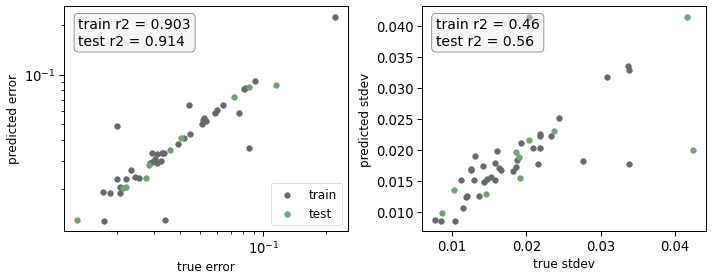

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))


# particle diameter distance from 300nm
ax0.scatter(train_values[:, 0], train_preds[:, 0], c='#666B6A', s=30, label='train')
ax0.scatter(test_values[:, 0], test_preds[:, 0], c='#72A276', s=30, label='test')

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlabel('true error', fontsize=12)
ax0.set_ylabel('predicted error', fontsize=12)

ax0.legend(loc='lower right', fontsize=12)

textstr = f'train r2 = {round(ps_train_r2, 3)}\ntest r2 = {round(ps_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax0.text(
    0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

# drug loading capacity
ax1.scatter(train_values[:, 1], train_preds[:, 1], c='#666B6A', s=30, label='train')
ax1.scatter(test_values[:, 1], test_preds[:, 1], c='#72A276', s=30, label='test')

ax1.set_xlabel('true stdev', fontsize=12)
ax1.set_ylabel('predicted stdev', fontsize=12)

textstr = f'train r2 = {round(dl_train_r2, 3)}\ntest r2 = {round(dl_test_r2, 3)}'
props = dict(boxstyle='round', facecolor='#f0eff4', alpha=0.5)
ax1.text(
    0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
    verticalalignment='top', bbox=props,
)

plt.tight_layout()

#plt.savefig('ace_100_pairity.png', dpi=400)

In [ ]:
np.where(train_preds[:, 0]<1e-2)

In [ ]:
train_params[37, :]